In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country.csv')
#ethnea_df

In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),2))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),2))                                                                

In [4]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [5]:
struct_dict_keys = {}
for i,key in enumerate(list(struct_dict.keys())):
    struct_dict_keys[key] = i
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [6]:
pub_series = ethnea_df.PubCountry.str.lower()
pub_keys = list(np.unique(pub_series.values))

In [7]:
# load test train data
with open('train_test_full_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainY,testY = pickle.load(f)

In [8]:
# transform the dataset into structure
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

In [9]:
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys[x]+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

def generate_batch(first_name,last_name, i, batch_size=10000):
    len_name = len(first_name)
    start = i*batch_size
    end = start+batch_size if start+batch_size < len_name else len_name
    len_mat = end - start
    #first_name_ds_mat = np.zeros((len_mat,len(struct_dict_keys)),dtype=np.int32)
    #last_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)

    first_name_ds_mat = first_name[start:end]
    first_name_ds_mat = pad_sequences(first_name_ds_mat.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    #first_name_ds_mat = first_name_ds_mat.reshape(first_name_ds_mat.shape[0],1,first_name_ds_mat.shape[1])
    
    last_name_ds_mat = last_name[start:end]
    last_name_ds_mat = pad_sequences(last_name_ds_mat.apply(lambda x:transform_structure(x)),maxlen=50,value=0.)
    #last_name_ds_mat = last_name_ds_mat.reshape(last_name_ds_mat.shape[0],1,last_name_ds_mat.shape[1])

    """
    for i in range(len_mat):
        x = first_name_struct.iloc[i]
        for y in x:
            first_name_ds_mat[i,struct_dict_keys[y]]+=1
        #x = last_name_struct.iloc[i]
        #for y in x:
        #    last_name_ds_mat[i,struct_dict_keys.index(y)]+=1
    """
    return first_name_ds_mat,last_name_ds_mat, range(start,end)

In [10]:
def transform_labels(x,my_keys):
    y = np.zeros(len(my_keys))
    if x in my_keys:
        y[my_keys.index(x)]=1
    return y


labels = np.array(list(map(lambda x: transform_labels(x,ethnic_keys),ethnic_series)))
#pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series)))

In [11]:
import numpy as np
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



Using TensorFlow backend.


In [12]:
import math

class OverSample:
    series = None
    series_counts = {}
    series_counts_list = None
    series_dist = {}    
    series_batch_dist = {}
    series_total = 0
    series_max = 0
    series_keys = None
    
    series_counter = 0
    series_batch = 0
    series_avg_dist = 0
    
    len_keys = 0
    
    last_batch_index = 0
    
    batch_count = 0
    batch_counter = 0
    
    distribution_type = 0
    
    max_batch_dist = 0
    
    randomized = False
    
    def __init__(self,series,keys,batch,distribution_type = 0,randomized = False):
        self.series = series
        self.series_keys = keys
        self.len_keys = len(keys)
        
        self.series_counts_list = np.zeros(self.len_keys)
        
        for val in keys:
            self.series_counts[val] = 0
            self.series_dist[val] = []
        for i,val in enumerate(series):
            self.series_counts[val] +=1
            self.series_dist[val].append(i)
            self.series_total+=1      
            self.series_counts_list[keys.index(val)]+=1
        for val in keys:
            if distribution_type == 0:
                self.series_batch_dist[val] =  math.floor(series_batch / self.len_keys)
            else:
                self.series_batch_dist[val] = math.ceil(self.series_counts_list[keys.index(val)]/self.series_total * batch)
            
            if self.series_batch_dist[val] > self.max_batch_dist:
                self.max_batch_dist =  self.series_batch_dist[val]
        
        self.series_max = self.series_counts_list.max()
        self.series_batch = batch
        self.series_avg_dist = math.floor(self.series_batch / self.len_keys)
        self.batch_count = math.ceil(self.series_max / self.max_batch_dist)
        self.batch_counter = self.batch_count
        self.distribution_type = distribution_type
        self.randomized = randomized
    
    
    def reset(self):
        self.last_batch_index = 0
        self.batch_counter = self.batch_count
    
    def genNext(self):
        return_index = []
        for ethnic in self.series_keys:
            series_avg_dist = self.series_batch_dist[ethnic]
            for x in range(series_avg_dist):
                if (self.last_batch_index + x) > self.series_max:
                    # break if it's greater than max
                    break;
                my_index = (self.last_batch_index + x) % len(self.series_dist[ethnic])
                return_index.append(self.series_dist[ethnic][my_index])
        self.last_batch_index = self.last_batch_index + self.max_batch_dist
        if self.randomized:
            np.random.shuffle(return_index)
        self.batch_counter-=1
        return return_index

In [13]:
from keras.models import model_from_json
# Model definition

# last_name_model

json_file = open('model-keras-w7-bigram-sep-last-full-lstm-embedding-cw2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

last_name_model = model_from_json(loaded_model_json)

#last_name_model.load_weights("model-keras-w7-bigram-sep-last-full-lstm-embedding-cw2-1.h5")
last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# first_name_model
json_file = open('model-keras-w7-bigram-sep-first-full-lstm-embedding-cw2.json')

loaded_model_json = json_file.read()
json_file.close()

first_name_model = model_from_json(loaded_model_json)

#first_name_model.load_weights('model-keras-w7-bigram-sep-first-full-lstm-embedding-cw2-1.h5')
first_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# first_name_pub_model

#first_name_pub_input = Input(shape=(len(pub_keys),),name='first_name_pub_input')
#merge_first_last = keras.layers.concatenate([fi,last_name_l])

In [14]:
last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           145200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 26)                1326      
Total params: 412,476
Trainable params: 412,476
Non-trainable params: 0
_________________________________________________________________


In [15]:
# change the name label for conflict issue
first_name_model.layers[0].name = "embedding_first_name"
first_name_model.layers[1].name = "bidirectional_first_name"
first_name_model.layers[2].name = "hidden_first_name_1"
first_name_model.layers[3].name = "hidden_first_name_2"
first_name_model.layers[4].name = "first_name_output"


last_name_model.layers[0].name = "embedding_last_name"
last_name_model.layers[1].name = "bidirectional_last_name"
last_name_model.layers[2].name = "hidden_last_name_1"
last_name_model.layers[3].name = "hidden_last_name_2"
last_name_model.layers[4].name = "last_name_output"

#first_name_model.get_layer('embedding_2_input').name='embedding_first_name_input'
last_name_model.get_layer('embedding_1_input').name='embedding_last_name_input'


last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_last_name (Embeddi (None, 50, 200)           145200    
_________________________________________________________________
bidirectional_last_name (Bid (None, 200)               240800    
_________________________________________________________________
hidden_last_name_1 (Dense)   (None, 100)               20100     
_________________________________________________________________
hidden_last_name_2 (Dense)   (None, 50)                5050      
_________________________________________________________________
last_name_output (Dense)     (None, 26)                1326      
Total params: 412,476
Trainable params: 412,476
Non-trainable params: 0
_________________________________________________________________


In [16]:
# integration
first_name_input = first_name_model.get_layer('embedding_first_name').input
#first_name_input.name = 'embedding_first_name_input'
#first_name_input = Input(shape=(None,50),name='first_name_input',dtype='float32')
first_name_output = first_name_model.get_layer('first_name_output').output

last_name_input = last_name_model.get_layer('embedding_last_name').input
#last_name_input.name = 'embedding_last_name_input'
#last_name_input = Input(shape=(None,50),name='last_name_input',dtype='float32')
last_name_output = last_name_model.get_layer('last_name_output').output

pub_input = Input(shape=(len(pub_keys),),name='pub_input')

# first_name_pub
merge_first_name_pub = keras.layers.concatenate([first_name_output,pub_input],name='merge_first_name_pub_1')
merge_first_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_name_pub_1')(merge_first_name_pub)
first_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_name_pub_output')(merge_first_name_pub_hidden)

# last_name_pub
merge_last_name_pub = keras.layers.concatenate([last_name_output,pub_input],name='merge_last_name_pub_1')
merge_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_last_name_pub_1')(merge_last_name_pub)
last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='last_name_pub_output')(merge_last_name_pub_hidden)

# first_last_name
merge_first_last = keras.layers.concatenate([first_name_output,last_name_output],name='merge_first_last_name_1')
merge_first_last_hidden = Dense(100, activation='relu',name='hidden_first_last_name_1')(merge_first_last)
first_last_name_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_output')(merge_first_last_hidden)

# first_last_name_pub
merge_first_last_name_pub = keras.layers.concatenate([first_name_output,last_name_output,pub_input],name='merge_first_last_name_pub')
merge_first_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_last_name_pub_1')(merge_first_last_name_pub)
first_last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_pub_output')(merge_first_last_name_pub_hidden)


first_last_name_model = Model(inputs=[first_name_input,last_name_input,pub_input], outputs=[first_name_output,last_name_output,first_name_pub_output,last_name_pub_output,first_last_name_output,first_last_name_pub_output])
first_last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
first_last_name_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2_input (InputLayer)   (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_last_name_input (Input (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_first_name (Embedding) (None, 50, 200)       145200      embedding_2_input[0][0]          
____________________________________________________________________________________________________
embedding_last_name (Embedding)  (None, 50, 200)       145200      embedding_last_name_input[0][0]  
___________________________________________________________________________________________

In [18]:
# calculate the weight balancing
from sklearn.utils import class_weight
labels_series = np.array(list(map(lambda x: ethnic_keys.index(x),ethnic_series)))
my_weight = class_weight.compute_class_weight('balanced',np.unique(labels_series[trainIndex]),labels_series[trainIndex])

In [19]:
mini_batch_size = 50000
sample = OverSample(ethnic_series[trainIndex],ethnic_keys,mini_batch_size,1)

In [20]:
sample.last_batch_index

0

In [21]:
first_last_name_model.load_weights('model-keras-w7-bigram-integration-full-lstm-embedding-cw2-checkpoint.h5')
#first_name_model.load_weights('model-keras-w7-bigram-sep-first-full-lstm-embedding-cw2-checkpoint.h5')
#last_name_model.load_weights('model-keras-w7-bigram-sep-last-full-lstm-embedding-cw2-checkpoint.h5')

In [24]:
sample.batch_counter = 33+1
sample.last_batch_index = (sample.batch_count - sample.batch_counter) * sample.max_batch_dist

In [24]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[my_weight,my_weight,my_weight,my_weight,my_weight,my_weight])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-cw2-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 290s - loss: 9.6767 - first_name_output_loss: 0.6841 - last_name_output_loss: 0.5583 - first_name_pub_output_loss: 2.2485 - last_name_pub_output_loss: 2.1240 - first_last_name_output_loss: 2.1206 - first_last_name_pub_output_loss: 1.9413 - first_name_output_acc: 0.8039 - last_name_output_acc: 0.8368 - first_name_pub_output_acc: 0.6754 - last_name_pub_output_acc: 0.6809 - first_last_name_output_acc: 0.7163 - first_last_name_pub_output_acc: 0.7336   
batch 69
Epoch 1/1
50014/50014 [==============================] - 291s - loss: 3.7527 - first_name_output_loss: 0.7006 - last_name_output_loss: 0.5732 - first_name_pub_output_loss: 0.7462 - last_name_pub_output_loss: 0.6643 - first_last_name_output_loss: 0.6119 - first_last_name_pub_output_loss: 0.4565 - first_name_output_acc: 0.8003 - last_name_output_acc: 0.8339 - first_name_pub_output_acc: 0.8437 - last_name_pub_output_acc: 0.8549 - first_last_name_output_acc: 0.8777 - firs

50014/50014 [==============================] - 276s - loss: 2.3896 - first_name_output_loss: 0.6470 - last_name_output_loss: 0.5514 - first_name_pub_output_loss: 0.4173 - last_name_pub_output_loss: 0.3411 - first_last_name_output_loss: 0.2469 - first_last_name_pub_output_loss: 0.1858 - first_name_output_acc: 0.8147 - last_name_output_acc: 0.8400 - first_name_pub_output_acc: 0.8906 - last_name_pub_output_acc: 0.8993 - first_last_name_output_acc: 0.9253 - first_last_name_pub_output_acc: 0.9439   
batch 39
Epoch 1/1
50014/50014 [==============================] - 275s - loss: 2.3825 - first_name_output_loss: 0.6452 - last_name_output_loss: 0.5433 - first_name_pub_output_loss: 0.4199 - last_name_pub_output_loss: 0.3385 - first_last_name_output_loss: 0.2470 - first_last_name_pub_output_loss: 0.1885 - first_name_output_acc: 0.8125 - last_name_output_acc: 0.8422 - first_name_pub_output_acc: 0.8913 - last_name_pub_output_acc: 0.9005 - first_last_name_output_acc: 0.9255 - first_last_name_pub_out

KeyboardInterrupt: 

In [25]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
#    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[my_weight,my_weight,my_weight,my_weight,my_weight,my_weight])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-cw2-checkpoint.h5')    


batch 33
Epoch 1/1
50014/50014 [==============================] - 271s - loss: 1.8846 - first_name_output_loss: 0.5192 - last_name_output_loss: 0.4024 - first_name_pub_output_loss: 0.3779 - last_name_pub_output_loss: 0.2816 - first_last_name_output_loss: 0.1654 - first_last_name_pub_output_loss: 0.1382 - first_name_output_acc: 0.8406 - last_name_output_acc: 0.8776 - first_name_pub_output_acc: 0.9009 - last_name_pub_output_acc: 0.9150 - first_last_name_output_acc: 0.9487 - first_last_name_pub_output_acc: 0.9567   
batch 32
Epoch 1/1
50014/50014 [==============================] - 283s - loss: 1.9001 - first_name_output_loss: 0.5220 - last_name_output_loss: 0.4075 - first_name_pub_output_loss: 0.3821 - last_name_pub_output_loss: 0.2849 - first_last_name_output_loss: 0.1644 - first_last_name_pub_output_loss: 0.1392 - first_name_output_acc: 0.8381 - last_name_output_acc: 0.8764 - first_name_pub_output_acc: 0.9009 - last_name_pub_output_acc: 0.9160 - first_last_name_output_acc: 0.9489 - firs

50014/50014 [==============================] - 276s - loss: 1.8970 - first_name_output_loss: 0.5340 - last_name_output_loss: 0.4126 - first_name_pub_output_loss: 0.3803 - last_name_pub_output_loss: 0.2781 - first_last_name_output_loss: 0.1590 - first_last_name_pub_output_loss: 0.1331 - first_name_output_acc: 0.8363 - last_name_output_acc: 0.8735 - first_name_pub_output_acc: 0.9007 - last_name_pub_output_acc: 0.9164 - first_last_name_output_acc: 0.9512 - first_last_name_pub_output_acc: 0.9591   
batch 17
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 1.9009 - first_name_output_loss: 0.5254 - last_name_output_loss: 0.4193 - first_name_pub_output_loss: 0.3735 - last_name_pub_output_loss: 0.2859 - first_last_name_output_loss: 0.1608 - first_last_name_pub_output_loss: 0.1361 - first_name_output_acc: 0.8402 - last_name_output_acc: 0.8724 - first_name_pub_output_acc: 0.9028 - last_name_pub_output_acc: 0.9157 - first_last_name_output_acc: 0.9504 - first_last_name_pub_out

50014/50014 [==============================] - 269s - loss: 1.8371 - first_name_output_loss: 0.5174 - last_name_output_loss: 0.4109 - first_name_pub_output_loss: 0.3624 - last_name_pub_output_loss: 0.2724 - first_last_name_output_loss: 0.1493 - first_last_name_pub_output_loss: 0.1248 - first_name_output_acc: 0.8422 - last_name_output_acc: 0.8772 - first_name_pub_output_acc: 0.9047 - last_name_pub_output_acc: 0.9183 - first_last_name_output_acc: 0.9548 - first_last_name_pub_output_acc: 0.9612   
batch 2
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 1.8648 - first_name_output_loss: 0.5261 - last_name_output_loss: 0.4162 - first_name_pub_output_loss: 0.3714 - last_name_pub_output_loss: 0.2723 - first_last_name_output_loss: 0.1529 - first_last_name_pub_output_loss: 0.1259 - first_name_output_acc: 0.8389 - last_name_output_acc: 0.8757 - first_name_pub_output_acc: 0.9025 - last_name_pub_output_acc: 0.9182 - first_last_name_output_acc: 0.9533 - first_last_name_pub_outp

In [26]:
mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(3):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-cw2-checkpoint.h5')                    
        nextList = sample.genNext()

batch 70
Epoch 1/1
50014/50014 [==============================] - 298s - loss: 1.8693 - first_name_output_loss: 0.5214 - last_name_output_loss: 0.4268 - first_name_pub_output_loss: 0.3608 - last_name_pub_output_loss: 0.2800 - first_last_name_output_loss: 0.1530 - first_last_name_pub_output_loss: 0.1273 - first_name_output_acc: 0.8405 - last_name_output_acc: 0.8720 - first_name_pub_output_acc: 0.9041 - last_name_pub_output_acc: 0.9156 - first_last_name_output_acc: 0.9533 - first_last_name_pub_output_acc: 0.9607   
batch 69
Epoch 1/1
50014/50014 [==============================] - 299s - loss: 1.8834 - first_name_output_loss: 0.5272 - last_name_output_loss: 0.4221 - first_name_pub_output_loss: 0.3727 - last_name_pub_output_loss: 0.2778 - first_last_name_output_loss: 0.1550 - first_last_name_pub_output_loss: 0.1285 - first_name_output_acc: 0.8392 - last_name_output_acc: 0.8745 - first_name_pub_output_acc: 0.9010 - last_name_pub_output_acc: 0.9158 - first_last_name_output_acc: 0.9532 - firs

50014/50014 [==============================] - 345s - loss: 1.8795 - first_name_output_loss: 0.5304 - last_name_output_loss: 0.4207 - first_name_pub_output_loss: 0.3744 - last_name_pub_output_loss: 0.2774 - first_last_name_output_loss: 0.1499 - first_last_name_pub_output_loss: 0.1267 - first_name_output_acc: 0.8386 - last_name_output_acc: 0.8731 - first_name_pub_output_acc: 0.9020 - last_name_pub_output_acc: 0.9159 - first_last_name_output_acc: 0.9536 - first_last_name_pub_output_acc: 0.9606   
batch 54
Epoch 1/1
50014/50014 [==============================] - 345s - loss: 1.8345 - first_name_output_loss: 0.5261 - last_name_output_loss: 0.4152 - first_name_pub_output_loss: 0.3635 - last_name_pub_output_loss: 0.2666 - first_last_name_output_loss: 0.1438 - first_last_name_pub_output_loss: 0.1193 - first_name_output_acc: 0.8412 - last_name_output_acc: 0.8751 - first_name_pub_output_acc: 0.9041 - last_name_pub_output_acc: 0.9197 - first_last_name_output_acc: 0.9553 - first_last_name_pub_out

50014/50014 [==============================] - 331s - loss: 1.8355 - first_name_output_loss: 0.5233 - last_name_output_loss: 0.4190 - first_name_pub_output_loss: 0.3566 - last_name_pub_output_loss: 0.2689 - first_last_name_output_loss: 0.1470 - first_last_name_pub_output_loss: 0.1205 - first_name_output_acc: 0.8419 - last_name_output_acc: 0.8731 - first_name_pub_output_acc: 0.9057 - last_name_pub_output_acc: 0.9190 - first_last_name_output_acc: 0.9546 - first_last_name_pub_output_acc: 0.9619   
batch 39
Epoch 1/1
50014/50014 [==============================] - 328s - loss: 1.8443 - first_name_output_loss: 0.5268 - last_name_output_loss: 0.4151 - first_name_pub_output_loss: 0.3640 - last_name_pub_output_loss: 0.2679 - first_last_name_output_loss: 0.1479 - first_last_name_pub_output_loss: 0.1226 - first_name_output_acc: 0.8391 - last_name_output_acc: 0.8763 - first_name_pub_output_acc: 0.9039 - last_name_pub_output_acc: 0.9193 - first_last_name_output_acc: 0.9542 - first_last_name_pub_out

50014/50014 [==============================] - 329s - loss: 1.8168 - first_name_output_loss: 0.5243 - last_name_output_loss: 0.4119 - first_name_pub_output_loss: 0.3582 - last_name_pub_output_loss: 0.2640 - first_last_name_output_loss: 0.1403 - first_last_name_pub_output_loss: 0.1181 - first_name_output_acc: 0.8405 - last_name_output_acc: 0.8745 - first_name_pub_output_acc: 0.9072 - last_name_pub_output_acc: 0.9200 - first_last_name_output_acc: 0.9574 - first_last_name_pub_output_acc: 0.9633   
batch 24
Epoch 1/1
50014/50014 [==============================] - 326s - loss: 1.8194 - first_name_output_loss: 0.5248 - last_name_output_loss: 0.4133 - first_name_pub_output_loss: 0.3652 - last_name_pub_output_loss: 0.2645 - first_last_name_output_loss: 0.1371 - first_last_name_pub_output_loss: 0.1144 - first_name_output_acc: 0.8409 - last_name_output_acc: 0.8753 - first_name_pub_output_acc: 0.9045 - last_name_pub_output_acc: 0.9201 - first_last_name_output_acc: 0.9575 - first_last_name_pub_out

50014/50014 [==============================] - 276s - loss: 1.8145 - first_name_output_loss: 0.5213 - last_name_output_loss: 0.4180 - first_name_pub_output_loss: 0.3539 - last_name_pub_output_loss: 0.2690 - first_last_name_output_loss: 0.1377 - first_last_name_pub_output_loss: 0.1145 - first_name_output_acc: 0.8399 - last_name_output_acc: 0.8743 - first_name_pub_output_acc: 0.9055 - last_name_pub_output_acc: 0.9180 - first_last_name_output_acc: 0.9576 - first_last_name_pub_output_acc: 0.9641   
batch 9
Epoch 1/1
50014/50014 [==============================] - 277s - loss: 1.8021 - first_name_output_loss: 0.5150 - last_name_output_loss: 0.4143 - first_name_pub_output_loss: 0.3591 - last_name_pub_output_loss: 0.2652 - first_last_name_output_loss: 0.1345 - first_last_name_pub_output_loss: 0.1140 - first_name_output_acc: 0.8431 - last_name_output_acc: 0.8763 - first_name_pub_output_acc: 0.9061 - last_name_pub_output_acc: 0.9192 - first_last_name_output_acc: 0.9597 - first_last_name_pub_outp

50014/50014 [==============================] - 278s - loss: 1.8261 - first_name_output_loss: 0.5294 - last_name_output_loss: 0.4196 - first_name_pub_output_loss: 0.3588 - last_name_pub_output_loss: 0.2690 - first_last_name_output_loss: 0.1361 - first_last_name_pub_output_loss: 0.1133 - first_name_output_acc: 0.8390 - last_name_output_acc: 0.8748 - first_name_pub_output_acc: 0.9051 - last_name_pub_output_acc: 0.9178 - first_last_name_output_acc: 0.9590 - first_last_name_pub_output_acc: 0.9648   
batch 65
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 1.8287 - first_name_output_loss: 0.5215 - last_name_output_loss: 0.4275 - first_name_pub_output_loss: 0.3562 - last_name_pub_output_loss: 0.2708 - first_last_name_output_loss: 0.1373 - first_last_name_pub_output_loss: 0.1153 - first_name_output_acc: 0.8426 - last_name_output_acc: 0.8725 - first_name_pub_output_acc: 0.9057 - last_name_pub_output_acc: 0.9176 - first_last_name_output_acc: 0.9578 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.8174 - first_name_output_loss: 0.5211 - last_name_output_loss: 0.4257 - first_name_pub_output_loss: 0.3502 - last_name_pub_output_loss: 0.2717 - first_last_name_output_loss: 0.1349 - first_last_name_pub_output_loss: 0.1138 - first_name_output_acc: 0.8413 - last_name_output_acc: 0.8724 - first_name_pub_output_acc: 0.9072 - last_name_pub_output_acc: 0.9180 - first_last_name_output_acc: 0.9586 - first_last_name_pub_output_acc: 0.9649   
batch 50
Epoch 1/1
50014/50014 [==============================] - 264s - loss: 1.8089 - first_name_output_loss: 0.5221 - last_name_output_loss: 0.4208 - first_name_pub_output_loss: 0.3529 - last_name_pub_output_loss: 0.2658 - first_last_name_output_loss: 0.1352 - first_last_name_pub_output_loss: 0.1122 - first_name_output_acc: 0.8398 - last_name_output_acc: 0.8751 - first_name_pub_output_acc: 0.9059 - last_name_pub_output_acc: 0.9194 - first_last_name_output_acc: 0.9581 - first_last_name_pub_out

50014/50014 [==============================] - 277s - loss: 1.7753 - first_name_output_loss: 0.5203 - last_name_output_loss: 0.4078 - first_name_pub_output_loss: 0.3506 - last_name_pub_output_loss: 0.2593 - first_last_name_output_loss: 0.1286 - first_last_name_pub_output_loss: 0.1086 - first_name_output_acc: 0.8412 - last_name_output_acc: 0.8763 - first_name_pub_output_acc: 0.9068 - last_name_pub_output_acc: 0.9207 - first_last_name_output_acc: 0.9608 - first_last_name_pub_output_acc: 0.9657   
batch 35
Epoch 1/1
50014/50014 [==============================] - 277s - loss: 1.7874 - first_name_output_loss: 0.5220 - last_name_output_loss: 0.4111 - first_name_pub_output_loss: 0.3520 - last_name_pub_output_loss: 0.2606 - first_last_name_output_loss: 0.1324 - first_last_name_pub_output_loss: 0.1094 - first_name_output_acc: 0.8407 - last_name_output_acc: 0.8763 - first_name_pub_output_acc: 0.9050 - last_name_pub_output_acc: 0.9200 - first_last_name_output_acc: 0.9587 - first_last_name_pub_out

50014/50014 [==============================] - 283s - loss: 1.7342 - first_name_output_loss: 0.5109 - last_name_output_loss: 0.4033 - first_name_pub_output_loss: 0.3412 - last_name_pub_output_loss: 0.2534 - first_last_name_output_loss: 0.1228 - first_last_name_pub_output_loss: 0.1026 - first_name_output_acc: 0.8421 - last_name_output_acc: 0.8774 - first_name_pub_output_acc: 0.9084 - last_name_pub_output_acc: 0.9238 - first_last_name_output_acc: 0.9616 - first_last_name_pub_output_acc: 0.9681   
batch 20
Epoch 1/1
50014/50014 [==============================] - 279s - loss: 1.7548 - first_name_output_loss: 0.5183 - last_name_output_loss: 0.4108 - first_name_pub_output_loss: 0.3468 - last_name_pub_output_loss: 0.2523 - first_last_name_output_loss: 0.1243 - first_last_name_pub_output_loss: 0.1024 - first_name_output_acc: 0.8413 - last_name_output_acc: 0.8789 - first_name_pub_output_acc: 0.9086 - last_name_pub_output_acc: 0.9217 - first_last_name_output_acc: 0.9624 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.7500 - first_name_output_loss: 0.5158 - last_name_output_loss: 0.4057 - first_name_pub_output_loss: 0.3440 - last_name_pub_output_loss: 0.2566 - first_last_name_output_loss: 0.1240 - first_last_name_pub_output_loss: 0.1039 - first_name_output_acc: 0.8417 - last_name_output_acc: 0.8773 - first_name_pub_output_acc: 0.9082 - last_name_pub_output_acc: 0.9214 - first_last_name_output_acc: 0.9611 - first_last_name_pub_output_acc: 0.9677   
batch 5
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 1.7259 - first_name_output_loss: 0.5172 - last_name_output_loss: 0.3988 - first_name_pub_output_loss: 0.3441 - last_name_pub_output_loss: 0.2466 - first_last_name_output_loss: 0.1197 - first_last_name_pub_output_loss: 0.0995 - first_name_output_acc: 0.8419 - last_name_output_acc: 0.8792 - first_name_pub_output_acc: 0.9085 - last_name_pub_output_acc: 0.9246 - first_last_name_output_acc: 0.9623 - first_last_name_pub_outp

50014/50014 [==============================] - 264s - loss: 1.7575 - first_name_output_loss: 0.5195 - last_name_output_loss: 0.4092 - first_name_pub_output_loss: 0.3498 - last_name_pub_output_loss: 0.2508 - first_last_name_output_loss: 0.1239 - first_last_name_pub_output_loss: 0.1043 - first_name_output_acc: 0.8424 - last_name_output_acc: 0.8776 - first_name_pub_output_acc: 0.9072 - last_name_pub_output_acc: 0.9228 - first_last_name_output_acc: 0.9613 - first_last_name_pub_output_acc: 0.9667   
batch 61
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.7548 - first_name_output_loss: 0.5165 - last_name_output_loss: 0.4148 - first_name_pub_output_loss: 0.3423 - last_name_pub_output_loss: 0.2527 - first_last_name_output_loss: 0.1260 - first_last_name_pub_output_loss: 0.1026 - first_name_output_acc: 0.8428 - last_name_output_acc: 0.8747 - first_name_pub_output_acc: 0.9086 - last_name_pub_output_acc: 0.9221 - first_last_name_output_acc: 0.9615 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.7198 - first_name_output_loss: 0.5146 - last_name_output_loss: 0.3985 - first_name_pub_output_loss: 0.3457 - last_name_pub_output_loss: 0.2440 - first_last_name_output_loss: 0.1183 - first_last_name_pub_output_loss: 0.0986 - first_name_output_acc: 0.8422 - last_name_output_acc: 0.8778 - first_name_pub_output_acc: 0.9087 - last_name_pub_output_acc: 0.9238 - first_last_name_output_acc: 0.9640 - first_last_name_pub_output_acc: 0.9692   
batch 46
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.7048 - first_name_output_loss: 0.5104 - last_name_output_loss: 0.3960 - first_name_pub_output_loss: 0.3397 - last_name_pub_output_loss: 0.2450 - first_last_name_output_loss: 0.1164 - first_last_name_pub_output_loss: 0.0971 - first_name_output_acc: 0.8440 - last_name_output_acc: 0.8801 - first_name_pub_output_acc: 0.9098 - last_name_pub_output_acc: 0.9252 - first_last_name_output_acc: 0.9643 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.7340 - first_name_output_loss: 0.5165 - last_name_output_loss: 0.4000 - first_name_pub_output_loss: 0.3487 - last_name_pub_output_loss: 0.2508 - first_last_name_output_loss: 0.1183 - first_last_name_pub_output_loss: 0.0997 - first_name_output_acc: 0.8412 - last_name_output_acc: 0.8792 - first_name_pub_output_acc: 0.9066 - last_name_pub_output_acc: 0.9229 - first_last_name_output_acc: 0.9637 - first_last_name_pub_output_acc: 0.9685   
batch 31
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.7268 - first_name_output_loss: 0.5128 - last_name_output_loss: 0.4043 - first_name_pub_output_loss: 0.3425 - last_name_pub_output_loss: 0.2525 - first_last_name_output_loss: 0.1164 - first_last_name_pub_output_loss: 0.0983 - first_name_output_acc: 0.8433 - last_name_output_acc: 0.8768 - first_name_pub_output_acc: 0.9083 - last_name_pub_output_acc: 0.9246 - first_last_name_output_acc: 0.9639 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.7058 - first_name_output_loss: 0.5107 - last_name_output_loss: 0.3975 - first_name_pub_output_loss: 0.3416 - last_name_pub_output_loss: 0.2493 - first_last_name_output_loss: 0.1119 - first_last_name_pub_output_loss: 0.0948 - first_name_output_acc: 0.8439 - last_name_output_acc: 0.8795 - first_name_pub_output_acc: 0.9092 - last_name_pub_output_acc: 0.9250 - first_last_name_output_acc: 0.9647 - first_last_name_pub_output_acc: 0.9690   
batch 16
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.6957 - first_name_output_loss: 0.5120 - last_name_output_loss: 0.3937 - first_name_pub_output_loss: 0.3429 - last_name_pub_output_loss: 0.2430 - first_last_name_output_loss: 0.1099 - first_last_name_pub_output_loss: 0.0942 - first_name_output_acc: 0.8442 - last_name_output_acc: 0.8819 - first_name_pub_output_acc: 0.9082 - last_name_pub_output_acc: 0.9249 - first_last_name_output_acc: 0.9657 - first_last_name_pub_out

50014/50014 [==============================] - 263s - loss: 1.7419 - first_name_output_loss: 0.5201 - last_name_output_loss: 0.4085 - first_name_pub_output_loss: 0.3478 - last_name_pub_output_loss: 0.2493 - first_last_name_output_loss: 0.1190 - first_last_name_pub_output_loss: 0.0973 - first_name_output_acc: 0.8421 - last_name_output_acc: 0.8766 - first_name_pub_output_acc: 0.9069 - last_name_pub_output_acc: 0.9220 - first_last_name_output_acc: 0.9635 - first_last_name_pub_output_acc: 0.9688   
batch 1
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.7385 - first_name_output_loss: 0.5169 - last_name_output_loss: 0.4077 - first_name_pub_output_loss: 0.3430 - last_name_pub_output_loss: 0.2526 - first_last_name_output_loss: 0.1184 - first_last_name_pub_output_loss: 0.0999 - first_name_output_acc: 0.8427 - last_name_output_acc: 0.8762 - first_name_pub_output_acc: 0.9094 - last_name_pub_output_acc: 0.9229 - first_last_name_output_acc: 0.9640 - first_last_name_pub_outp

In [27]:
mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(3):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-cw2-checkpoint.h5')                    
        nextList = sample.genNext()

batch 70
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 1.7123 - first_name_output_loss: 0.5089 - last_name_output_loss: 0.4079 - first_name_pub_output_loss: 0.3346 - last_name_pub_output_loss: 0.2504 - first_last_name_output_loss: 0.1141 - first_last_name_pub_output_loss: 0.0965 - first_name_output_acc: 0.8443 - last_name_output_acc: 0.8783 - first_name_pub_output_acc: 0.9095 - last_name_pub_output_acc: 0.9240 - first_last_name_output_acc: 0.9654 - first_last_name_pub_output_acc: 0.9702   
batch 69
Epoch 1/1
50014/50014 [==============================] - 264s - loss: 1.7232 - first_name_output_loss: 0.5145 - last_name_output_loss: 0.4017 - first_name_pub_output_loss: 0.3457 - last_name_pub_output_loss: 0.2470 - first_last_name_output_loss: 0.1166 - first_last_name_pub_output_loss: 0.0976 - first_name_output_acc: 0.8420 - last_name_output_acc: 0.8802 - first_name_pub_output_acc: 0.9065 - last_name_pub_output_acc: 0.9245 - first_last_name_output_acc: 0.9644 - firs

50014/50014 [==============================] - 263s - loss: 1.7000 - first_name_output_loss: 0.5122 - last_name_output_loss: 0.3954 - first_name_pub_output_loss: 0.3464 - last_name_pub_output_loss: 0.2451 - first_last_name_output_loss: 0.1079 - first_last_name_pub_output_loss: 0.0929 - first_name_output_acc: 0.8418 - last_name_output_acc: 0.8794 - first_name_pub_output_acc: 0.9070 - last_name_pub_output_acc: 0.9246 - first_last_name_output_acc: 0.9670 - first_last_name_pub_output_acc: 0.9709   
batch 54
Epoch 1/1
50014/50014 [==============================] - 263s - loss: 1.6725 - first_name_output_loss: 0.5100 - last_name_output_loss: 0.3950 - first_name_pub_output_loss: 0.3375 - last_name_pub_output_loss: 0.2385 - first_last_name_output_loss: 0.1046 - first_last_name_pub_output_loss: 0.0869 - first_name_output_acc: 0.8443 - last_name_output_acc: 0.8824 - first_name_pub_output_acc: 0.9099 - last_name_pub_output_acc: 0.9271 - first_last_name_output_acc: 0.9676 - first_last_name_pub_out

50014/50014 [==============================] - 269s - loss: 1.7108 - first_name_output_loss: 0.5113 - last_name_output_loss: 0.4038 - first_name_pub_output_loss: 0.3377 - last_name_pub_output_loss: 0.2462 - first_last_name_output_loss: 0.1156 - first_last_name_pub_output_loss: 0.0963 - first_name_output_acc: 0.8440 - last_name_output_acc: 0.8776 - first_name_pub_output_acc: 0.9099 - last_name_pub_output_acc: 0.9245 - first_last_name_output_acc: 0.9639 - first_last_name_pub_output_acc: 0.9689   
batch 39
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 1.7161 - first_name_output_loss: 0.5142 - last_name_output_loss: 0.3982 - first_name_pub_output_loss: 0.3405 - last_name_pub_output_loss: 0.2475 - first_last_name_output_loss: 0.1172 - first_last_name_pub_output_loss: 0.0986 - first_name_output_acc: 0.8430 - last_name_output_acc: 0.8806 - first_name_pub_output_acc: 0.9088 - last_name_pub_output_acc: 0.9253 - first_last_name_output_acc: 0.9640 - first_last_name_pub_out

50014/50014 [==============================] - 296s - loss: 1.6818 - first_name_output_loss: 0.5143 - last_name_output_loss: 0.3891 - first_name_pub_output_loss: 0.3397 - last_name_pub_output_loss: 0.2383 - first_last_name_output_loss: 0.1091 - first_last_name_pub_output_loss: 0.0913 - first_name_output_acc: 0.8439 - last_name_output_acc: 0.8802 - first_name_pub_output_acc: 0.9098 - last_name_pub_output_acc: 0.9265 - first_last_name_output_acc: 0.9663 - first_last_name_pub_output_acc: 0.9712   
batch 24
Epoch 1/1
50014/50014 [==============================] - 297s - loss: 1.7004 - first_name_output_loss: 0.5144 - last_name_output_loss: 0.3968 - first_name_pub_output_loss: 0.3464 - last_name_pub_output_loss: 0.2438 - first_last_name_output_loss: 0.1080 - first_last_name_pub_output_loss: 0.0909 - first_name_output_acc: 0.8438 - last_name_output_acc: 0.8804 - first_name_pub_output_acc: 0.9078 - last_name_pub_output_acc: 0.9258 - first_last_name_output_acc: 0.9664 - first_last_name_pub_out

50014/50014 [==============================] - 276s - loss: 1.6833 - first_name_output_loss: 0.5089 - last_name_output_loss: 0.3969 - first_name_pub_output_loss: 0.3349 - last_name_pub_output_loss: 0.2461 - first_last_name_output_loss: 0.1071 - first_last_name_pub_output_loss: 0.0895 - first_name_output_acc: 0.8425 - last_name_output_acc: 0.8803 - first_name_pub_output_acc: 0.9096 - last_name_pub_output_acc: 0.9245 - first_last_name_output_acc: 0.9676 - first_last_name_pub_output_acc: 0.9725   
batch 9
Epoch 1/1
50014/50014 [==============================] - 278s - loss: 1.7003 - first_name_output_loss: 0.5078 - last_name_output_loss: 0.3986 - first_name_pub_output_loss: 0.3417 - last_name_pub_output_loss: 0.2451 - first_last_name_output_loss: 0.1117 - first_last_name_pub_output_loss: 0.0955 - first_name_output_acc: 0.8450 - last_name_output_acc: 0.8802 - first_name_pub_output_acc: 0.9088 - last_name_pub_output_acc: 0.9241 - first_last_name_output_acc: 0.9657 - first_last_name_pub_outp

50014/50014 [==============================] - 277s - loss: 1.6973 - first_name_output_loss: 0.5126 - last_name_output_loss: 0.4003 - first_name_pub_output_loss: 0.3391 - last_name_pub_output_loss: 0.2467 - first_last_name_output_loss: 0.1080 - first_last_name_pub_output_loss: 0.0906 - first_name_output_acc: 0.8432 - last_name_output_acc: 0.8773 - first_name_pub_output_acc: 0.9084 - last_name_pub_output_acc: 0.9240 - first_last_name_output_acc: 0.9667 - first_last_name_pub_output_acc: 0.9712   
batch 65
Epoch 1/1
50014/50014 [==============================] - 286s - loss: 1.7023 - first_name_output_loss: 0.5086 - last_name_output_loss: 0.4053 - first_name_pub_output_loss: 0.3392 - last_name_pub_output_loss: 0.2479 - first_last_name_output_loss: 0.1086 - first_last_name_pub_output_loss: 0.0926 - first_name_output_acc: 0.8449 - last_name_output_acc: 0.8780 - first_name_pub_output_acc: 0.9093 - last_name_pub_output_acc: 0.9235 - first_last_name_output_acc: 0.9667 - first_last_name_pub_out

50014/50014 [==============================] - 272s - loss: 1.6870 - first_name_output_loss: 0.5077 - last_name_output_loss: 0.4025 - first_name_pub_output_loss: 0.3326 - last_name_pub_output_loss: 0.2476 - first_last_name_output_loss: 0.1069 - first_last_name_pub_output_loss: 0.0898 - first_name_output_acc: 0.8439 - last_name_output_acc: 0.8780 - first_name_pub_output_acc: 0.9104 - last_name_pub_output_acc: 0.9235 - first_last_name_output_acc: 0.9667 - first_last_name_pub_output_acc: 0.9720   
batch 50
Epoch 1/1
50014/50014 [==============================] - 275s - loss: 1.6786 - first_name_output_loss: 0.5097 - last_name_output_loss: 0.3952 - first_name_pub_output_loss: 0.3354 - last_name_pub_output_loss: 0.2423 - first_last_name_output_loss: 0.1072 - first_last_name_pub_output_loss: 0.0889 - first_name_output_acc: 0.8412 - last_name_output_acc: 0.8806 - first_name_pub_output_acc: 0.9094 - last_name_pub_output_acc: 0.9259 - first_last_name_output_acc: 0.9663 - first_last_name_pub_out

50014/50014 [==============================] - 264s - loss: 1.6659 - first_name_output_loss: 0.5059 - last_name_output_loss: 0.3902 - first_name_pub_output_loss: 0.3343 - last_name_pub_output_loss: 0.2405 - first_last_name_output_loss: 0.1057 - first_last_name_pub_output_loss: 0.0892 - first_name_output_acc: 0.8437 - last_name_output_acc: 0.8809 - first_name_pub_output_acc: 0.9102 - last_name_pub_output_acc: 0.9255 - first_last_name_output_acc: 0.9675 - first_last_name_pub_output_acc: 0.9716   
batch 35
Epoch 1/1
50014/50014 [==============================] - 266s - loss: 1.6608 - first_name_output_loss: 0.5071 - last_name_output_loss: 0.3905 - first_name_pub_output_loss: 0.3348 - last_name_pub_output_loss: 0.2395 - first_last_name_output_loss: 0.1033 - first_last_name_pub_output_loss: 0.0856 - first_name_output_acc: 0.8447 - last_name_output_acc: 0.8833 - first_name_pub_output_acc: 0.9087 - last_name_pub_output_acc: 0.9255 - first_last_name_output_acc: 0.9680 - first_last_name_pub_out

50014/50014 [==============================] - 275s - loss: 1.6197 - first_name_output_loss: 0.4984 - last_name_output_loss: 0.3806 - first_name_pub_output_loss: 0.3260 - last_name_pub_output_loss: 0.2339 - first_last_name_output_loss: 0.0980 - first_last_name_pub_output_loss: 0.0828 - first_name_output_acc: 0.8451 - last_name_output_acc: 0.8834 - first_name_pub_output_acc: 0.9123 - last_name_pub_output_acc: 0.9279 - first_last_name_output_acc: 0.9697 - first_last_name_pub_output_acc: 0.9742   
batch 20
Epoch 1/1
50014/50014 [==============================] - 281s - loss: 1.6556 - first_name_output_loss: 0.5074 - last_name_output_loss: 0.3919 - first_name_pub_output_loss: 0.3340 - last_name_pub_output_loss: 0.2363 - first_last_name_output_loss: 0.1016 - first_last_name_pub_output_loss: 0.0846 - first_name_output_acc: 0.8425 - last_name_output_acc: 0.8834 - first_name_pub_output_acc: 0.9100 - last_name_pub_output_acc: 0.9267 - first_last_name_output_acc: 0.9688 - first_last_name_pub_out

50014/50014 [==============================] - 277s - loss: 1.6493 - first_name_output_loss: 0.5070 - last_name_output_loss: 0.3870 - first_name_pub_output_loss: 0.3324 - last_name_pub_output_loss: 0.2372 - first_last_name_output_loss: 0.1011 - first_last_name_pub_output_loss: 0.0846 - first_name_output_acc: 0.8426 - last_name_output_acc: 0.8819 - first_name_pub_output_acc: 0.9104 - last_name_pub_output_acc: 0.9263 - first_last_name_output_acc: 0.9689 - first_last_name_pub_output_acc: 0.9730   
batch 5
Epoch 1/1
50014/50014 [==============================] - 276s - loss: 1.6449 - first_name_output_loss: 0.5091 - last_name_output_loss: 0.3851 - first_name_pub_output_loss: 0.3321 - last_name_pub_output_loss: 0.2318 - first_last_name_output_loss: 0.1020 - first_last_name_pub_output_loss: 0.0848 - first_name_output_acc: 0.8435 - last_name_output_acc: 0.8825 - first_name_pub_output_acc: 0.9112 - last_name_pub_output_acc: 0.9296 - first_last_name_output_acc: 0.9674 - first_last_name_pub_outp

50014/50014 [==============================] - 282s - loss: 1.6613 - first_name_output_loss: 0.5085 - last_name_output_loss: 0.3930 - first_name_pub_output_loss: 0.3362 - last_name_pub_output_loss: 0.2362 - first_last_name_output_loss: 0.1015 - first_last_name_pub_output_loss: 0.0860 - first_name_output_acc: 0.8451 - last_name_output_acc: 0.8830 - first_name_pub_output_acc: 0.9096 - last_name_pub_output_acc: 0.9256 - first_last_name_output_acc: 0.9682 - first_last_name_pub_output_acc: 0.9725   
batch 61
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 1.6554 - first_name_output_loss: 0.5058 - last_name_output_loss: 0.3964 - first_name_pub_output_loss: 0.3296 - last_name_pub_output_loss: 0.2371 - first_last_name_output_loss: 0.1022 - first_last_name_pub_output_loss: 0.0844 - first_name_output_acc: 0.8442 - last_name_output_acc: 0.8797 - first_name_pub_output_acc: 0.9116 - last_name_pub_output_acc: 0.9269 - first_last_name_output_acc: 0.9685 - first_last_name_pub_out

50014/50014 [==============================] - 284s - loss: 1.6431 - first_name_output_loss: 0.5059 - last_name_output_loss: 0.3862 - first_name_pub_output_loss: 0.3359 - last_name_pub_output_loss: 0.2312 - first_last_name_output_loss: 0.1000 - first_last_name_pub_output_loss: 0.0839 - first_name_output_acc: 0.8453 - last_name_output_acc: 0.8805 - first_name_pub_output_acc: 0.9106 - last_name_pub_output_acc: 0.9278 - first_last_name_output_acc: 0.9696 - first_last_name_pub_output_acc: 0.9735   
batch 46
Epoch 1/1
50014/50014 [==============================] - 278s - loss: 1.6269 - first_name_output_loss: 0.5037 - last_name_output_loss: 0.3820 - first_name_pub_output_loss: 0.3303 - last_name_pub_output_loss: 0.2301 - first_last_name_output_loss: 0.0987 - first_last_name_pub_output_loss: 0.0821 - first_name_output_acc: 0.8460 - last_name_output_acc: 0.8840 - first_name_pub_output_acc: 0.9122 - last_name_pub_output_acc: 0.9284 - first_last_name_output_acc: 0.9687 - first_last_name_pub_out

50014/50014 [==============================] - 279s - loss: 1.6360 - first_name_output_loss: 0.5069 - last_name_output_loss: 0.3789 - first_name_pub_output_loss: 0.3383 - last_name_pub_output_loss: 0.2326 - first_last_name_output_loss: 0.0973 - first_last_name_pub_output_loss: 0.0820 - first_name_output_acc: 0.8440 - last_name_output_acc: 0.8859 - first_name_pub_output_acc: 0.9089 - last_name_pub_output_acc: 0.9281 - first_last_name_output_acc: 0.9707 - first_last_name_pub_output_acc: 0.9750   
batch 31
Epoch 1/1
50014/50014 [==============================] - 283s - loss: 1.6421 - first_name_output_loss: 0.5006 - last_name_output_loss: 0.3913 - first_name_pub_output_loss: 0.3309 - last_name_pub_output_loss: 0.2383 - first_last_name_output_loss: 0.0979 - first_last_name_pub_output_loss: 0.0831 - first_name_output_acc: 0.8474 - last_name_output_acc: 0.8815 - first_name_pub_output_acc: 0.9109 - last_name_pub_output_acc: 0.9268 - first_last_name_output_acc: 0.9691 - first_last_name_pub_out

50014/50014 [==============================] - 282s - loss: 1.6281 - first_name_output_loss: 0.5030 - last_name_output_loss: 0.3829 - first_name_pub_output_loss: 0.3315 - last_name_pub_output_loss: 0.2357 - first_last_name_output_loss: 0.0951 - first_last_name_pub_output_loss: 0.0799 - first_name_output_acc: 0.8455 - last_name_output_acc: 0.8820 - first_name_pub_output_acc: 0.9108 - last_name_pub_output_acc: 0.9282 - first_last_name_output_acc: 0.9702 - first_last_name_pub_output_acc: 0.9741   
batch 16
Epoch 1/1
50014/50014 [==============================] - 282s - loss: 1.6283 - first_name_output_loss: 0.5050 - last_name_output_loss: 0.3819 - first_name_pub_output_loss: 0.3343 - last_name_pub_output_loss: 0.2308 - first_last_name_output_loss: 0.0959 - first_last_name_pub_output_loss: 0.0804 - first_name_output_acc: 0.8449 - last_name_output_acc: 0.8839 - first_name_pub_output_acc: 0.9100 - last_name_pub_output_acc: 0.9283 - first_last_name_output_acc: 0.9688 - first_last_name_pub_out

50014/50014 [==============================] - 276s - loss: 1.6432 - first_name_output_loss: 0.5092 - last_name_output_loss: 0.3859 - first_name_pub_output_loss: 0.3365 - last_name_pub_output_loss: 0.2320 - first_last_name_output_loss: 0.0987 - first_last_name_pub_output_loss: 0.0809 - first_name_output_acc: 0.8446 - last_name_output_acc: 0.8836 - first_name_pub_output_acc: 0.9092 - last_name_pub_output_acc: 0.9276 - first_last_name_output_acc: 0.9699 - first_last_name_pub_output_acc: 0.9749   
batch 1
Epoch 1/1
50014/50014 [==============================] - 292s - loss: 1.6345 - first_name_output_loss: 0.5056 - last_name_output_loss: 0.3874 - first_name_pub_output_loss: 0.3310 - last_name_pub_output_loss: 0.2341 - first_last_name_output_loss: 0.0959 - first_last_name_pub_output_loss: 0.0804 - first_name_output_acc: 0.8452 - last_name_output_acc: 0.8816 - first_name_pub_output_acc: 0.9114 - last_name_pub_output_acc: 0.9278 - first_last_name_output_acc: 0.9710 - first_last_name_pub_outp

In [228]:
index = ["first_name","last_name","first_name_pub","last_name_pub","first_last_name","first_last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]

def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    """
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    """
    trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    #trans_name = trans_name.reshape(trans_name.shape[0],1,trans_name.shape[1])
    return trans_name

def predict_ethnicity(fname="",lname="",pub="",first_last_name_model=first_last_name_model,is_sentence=True):
    # lower case the name
    if is_sentence:
        fnamex = np.array(trans_name(fname))
        lnamex = np.array(trans_name(lname))
        pub_country = transform_labels(pub.lower(),pub_keys)
    else:
        fnamex = fname
        lnamex = lname
        pub_country = pub
    preds = first_last_name_model.predict([fnamex,lnamex,pub_country])
    return_item = {}
    p_fname  = {}
    p_lname = {}
    p_fname_pub = {}
    p_lname_pub = {}
    p_type = 0
    if fname!="" and lname=="":
        if np.sum(pub_country) == 0 :
            p_type = 1
        else:
            p_type = 2
    elif fname=="" and lname!="":
        if np.sum(pub_country) == 0 :
            p_type = 3
        else:
            p_type = 4
    elif np.sum(pub_country) == 0:
        p_type = 5

    outputs = {}
    outputs[0] = ["first_last_name","first_last_name_join","first_last_name_pub","first_name","first_name_pub","last_name","last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]
    outputs[1] = ["first_name"]
    outputs[2] = ["first_name","first_name_pub"]
    outputs[3] = ["last_name"]
    outputs[4] = ["last_name","last_name_pub"]
    outputs[5] = ["first_last_name","first_last_name_join","first_name","last_name"]
        
    for i,pred in enumerate(preds):
        classes = []
        for x in np.argsort(pred[0])[::-1]:
            classes.append((ethnic_keys[x],pred[0][x]))
            if index[i] == "first_name":
                p_fname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name":
                p_lname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "first_name_pub":
                p_fname_pub[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name_pub":
                p_lname_pub[ethnic_keys[x]] = pred[0][x]

        return_item[index[i]] = classes
        
    # first name last name join prob
    join_result = {}
    join_result_pub = {}
    join_result_first_pub_last = {}
    join_result_last_pub_first = {}
    total = 0
    total_pub = 0
    total_first_pub_last = 0
    total_last_pub_first = 0
    
    for eth in ethnic_keys:
        join = p_fname[eth] * p_lname[eth]
        join_pub = p_fname_pub[eth] * p_lname_pub[eth]
        join_first_pub_last = p_fname_pub[eth] * p_lname[eth]
        join_last_pub_first = p_fname[eth] * p_lname_pub[eth]
        join_result[eth] = join
        join_result_pub[eth] = join_pub
        join_result_first_pub_last[eth] = join_first_pub_last
        join_result_last_pub_first[eth] = join_last_pub_first
        total += join
        total_pub += join_pub
        total_first_pub_last += join_first_pub_last
        total_last_pub_first += join_last_pub_first
        
    # normalize
    join_result_list = []
    join_pub_result_list = []
    join_first_pub_last_result_list = []
    join_last_pub_first_result_list = []
    for eth in ethnic_keys:
        join_result_list.append((eth,join_result[eth] / total))
        join_pub_result_list.append((eth,join_result_pub[eth]/total_pub))
        join_first_pub_last_result_list.append((eth,join_result_first_pub_last[eth]/total_first_pub_last))
        join_last_pub_first_result_list.append((eth,join_result_last_pub_first[eth]/total_last_pub_first))
    
    join_result_list = sorted(join_result_list, key=lambda x:x[1])[::-1]
    join_pub_result_list = sorted(join_pub_result_list, key=lambda x:x[1])[::-1]
    join_first_pub_last_result_list = sorted(join_first_pub_last_result_list, key=lambda x:x[1])[::-1]
    join_last_pub_first_result_list = sorted(join_last_pub_first_result_list, key=lambda x:x[1])[::-1]
    
    return_item["first_last_name_join"] = join_result_list
    return_item["first_last_name_pub_join"] = join_pub_result_list
    return_item["first_pub_last_name_join"] = join_first_pub_last_result_list
    return_item["last_pub_first_name_join"] = join_last_pub_first_result_list
    
    rendered_return = {}
    # render the output
    for key in outputs[p_type]:
        rendered_return[key] = return_item[key]
    
    return rendered_return

In [175]:
test = predict_ethnicity('Nikolaus','Parulian','')
pd.DataFrame(test)
#trans_name('Nikolaus')
#x = [(1,2,3),(2,3,4),(2,1,3)]
#sorted(x,key=lambda x: x[1])[::-1]

,first_last_name,first_last_name_join,first_name,last_name
0,"(german, 0.991626)","(german, 0.990145451309)","(german, 0.98938)","(english, 0.630911)"
1,"(english, 0.00784641)","(english, 0.00928075223435)","(french, 0.00478916)","(arab, 0.0975618)"
2,"(dutch, 0.000115931)","(french, 0.00049463247131)","(nordic, 0.00306016)","(german, 0.0876464)"
3,"(french, 9.37702e-05)","(hispanic, 5.35609391275e-05)","(english, 0.00128829)","(hispanic, 0.0704712)"
4,"(slav, 9.31148e-05)","(dutch, 1.26656171638e-05)","(dutch, 0.00110912)","(slav, 0.0585843)"
5,"(hispanic, 4.95293e-05)","(nordic, 5.4010668618e-06)","(african, 0.000226174)","(indian, 0.0117512)"
6,"(african, 4.22928e-05)","(greek, 3.36025585025e-06)","(hispanic, 6.65632e-05)","(french, 0.00904527)"
7,"(nordic, 3.70875e-05)","(slav, 1.33770464541e-06)","(greek, 4.5439e-05)","(italian, 0.00791742)"
8,"(arab, 3.44734e-05)","(italian, 1.19203339325e-06)","(italian, 1.31857e-05)","(greek, 0.00647651)"
9,"(israeli, 1.63647e-05)","(african, 9.62840581434e-07)","(chinese, 1.16361e-05)","(israeli, 0.00499941)"


In [30]:
# store the predictions probabilities, predictions and labels
def evaluate_probs(firstX, lastX, pub_series, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = [[],[],[],[],[],[]]
    pred_prob = [[],[],[],[],[],[]]
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        preds = first_last_name_model.predict([y_first_trainX,y_last_trainX,pub_country],batch_size=1000)
        #print(len(preds))
        #print(len(preds[0]))
        for i,pred in enumerate(preds):
            pred_class[i].extend([np.argsort(x)[::-1][0] for x in pred])
            pred_prob[i].extend([x[np.argsort(x)[::-1][0]] for x in pred])
        #print(len(pred_class))
        #print(len(pred_class[0]))
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [31]:
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, pub_series, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [24]:
with open('evaluationcw-2.pickle','rb') as file:
    pred_class,pred_prob = pickle.load(file)

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        # precision
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]
        # recall
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [30]:
#test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
test_labels = testY

In [31]:
for i,x in enumerate(np.array(pred_class)):
    print("{} : {}".format(index[i],np.sum(x==test_labels)/len(test_labels)))

first_name : 0.8375143913569542
last_name : 0.859843688156632
first_name_pub : 0.9044774739320514
last_name_pub : 0.9097356049782537
first_last_name : 0.9516224880668729
first_last_name_pub : 0.9590163472283458


In [32]:
def conf_table(pred_class,testY):
    cnf_matrix = confusion_matrix(testY,pred_class)
    precision = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)[np.newaxis,:]
    recall = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    prec_df = pd.DataFrame(index=ethnic_keys)
    prec_df["precision"] = None
    prec_df["recall"] = None
    prec_list = []
    recall_list = []
    second_prec = [[],[],[]]
    second_recall = [[],[],[]]
    for i,key in enumerate(ethnic_keys):
        #df_row = {'precision': precision[i,i],'recall':recall[i,i]}
        #prec_df.iloc[i].map(df_row)
        prec_list.append(precision[i,i])    
        recall_list.append(recall[i,i])
        for j in range(3):
            t =  np.argsort(precision[:,i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = precision[t,i]
            second_prec[j].append((et,etval))
            t =  np.argsort(recall[i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = recall[i,t]
            second_recall[j].append((et,etval))
        #prec_df.iloc[i,'precision'] = precision[i,i]
    prec_df['precision'] = prec_list
    prec_df['recall'] = recall_list
    for i, prec_tmp in enumerate(second_prec):
        prec_df["precision-{}".format(i+1)] = prec_tmp
    for i, rec_tmp in enumerate(second_recall):
        prec_df["recall-{}".format(i+1)] = rec_tmp
    return prec_df

In [33]:
from IPython.display import display
for i,pred in enumerate(pred_class):
    print("Precision {}".format(index[i]))
    display(conf_table(pred,test_labels))

Precision first_name


/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.612579,0.315890,"(african, 0.612579281184)","(hispanic, 0.0671247357294)","(english, 0.0544397463002)","(english, 0.333060779504)","(african, 0.315889888253)","(indian, 0.0542382120469)"
arab,0.857050,0.891822,"(arab, 0.857050196389)","(turkish, 0.0292241721019)","(indian, 0.0205037656301)","(arab, 0.891821965578)","(indian, 0.0289849638157)","(english, 0.0198732610897)"
baltic,0.796954,0.632215,"(baltic, 0.796954314721)","(hispanic, 0.0507614213198)","(nordic, 0.0287648054146)","(baltic, 0.632214765101)","(slav, 0.10067114094)","(hispanic, 0.0832214765101)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.333333333333)","(indian, 0.285714285714)","(arab, 0.142857142857)"
chinese,0.958850,0.924983,"(chinese, 0.958849709846)","(korean, 0.00986033244812)","(japanese, 0.00684813612668)","(chinese, 0.924982802382)","(english, 0.0395901036601)","(korean, 0.0109234528074)"
dutch,0.793381,0.404239,"(dutch, 0.793380831993)","(german, 0.0626292806251)","(french, 0.0321765111469)","(dutch, 0.40423912407)","(english, 0.27513320452)","(german, 0.118273903624)"
english,0.813246,0.944585,"(english, 0.813246312601)","(german, 0.0551134618767)","(french, 0.0330710586495)","(english, 0.944584504994)","(german, 0.0159784460667)","(hispanic, 0.0103302350709)"
french,0.796733,0.650501,"(french, 0.796733360555)","(english, 0.0798421124268)","(dutch, 0.0309514087383)","(french, 0.650501189074)","(english, 0.24652723757)","(german, 0.0375391727602)"
german,0.729424,0.633418,"(german, 0.729424327426)","(english, 0.073536911896)","(nordic, 0.0545390794339)","(german, 0.633418219061)","(english, 0.255833587068)","(hispanic, 0.0240263514823)"
greek,0.896700,0.707113,"(greek, 0.896700381363)","(slav, 0.0261979771182)","(hispanic, 0.0200630077931)","(greek, 0.707112970711)","(english, 0.146443514644)","(hispanic, 0.0689069037657)"


Precision last_name


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.579313,0.454892,"(african, 0.579312738632)","(french, 0.0805275945852)","(english, 0.0558833738285)","(african, 0.454892341237)","(english, 0.108476424094)","(hispanic, 0.0545107658763)"
arab,0.801568,0.866399,"(arab, 0.801568028863)","(english, 0.0381946853535)","(french, 0.0329563588427)","(arab, 0.866399190071)","(english, 0.025272788631)","(indian, 0.0250103115977)"
baltic,0.733918,0.673826,"(baltic, 0.733918128655)","(english, 0.0877192982456)","(hispanic, 0.0453216374269)","(baltic, 0.673825503356)","(greek, 0.0845637583893)","(english, 0.0818791946309)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.52380952381)","(indian, 0.238095238095)","(slav, 0.0952380952381)"
chinese,0.939240,0.961442,"(chinese, 0.939240154333)","(english, 0.0333344919879)","(korean, 0.0180981843883)","(chinese, 0.961441753445)","(korean, 0.0201864459046)","(english, 0.00817183385915)"
dutch,0.776559,0.746004,"(dutch, 0.776558785884)","(french, 0.053635643323)","(english, 0.0527823489974)","(dutch, 0.746003864395)","(german, 0.0815621523508)","(english, 0.0765852801686)"
english,0.896946,0.889491,"(english, 0.896945845148)","(german, 0.0266758391418)","(french, 0.0203447360702)","(english, 0.889491072294)","(german, 0.0404413292516)","(chinese, 0.00996315330166)"
french,0.759613,0.616429,"(french, 0.759613277826)","(english, 0.0666904031551)","(hispanic, 0.0457109991236)","(french, 0.616429222323)","(english, 0.129486809059)","(german, 0.065610206032)"
german,0.729563,0.810391,"(german, 0.729563039659)","(english, 0.145503931023)","(french, 0.0367809217658)","(german, 0.810391120215)","(english, 0.105724250561)","(slav, 0.0167464777037)"
greek,0.799029,0.860879,"(greek, 0.799029126214)","(english, 0.0597087378641)","(french, 0.027427184466)","(greek, 0.860878661088)","(english, 0.0240585774059)","(hispanic, 0.0227510460251)"


Precision first_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.683956,0.539111,"(african, 0.683955739972)","(english, 0.097510373444)","(hispanic, 0.0380359612725)","(african, 0.539111474516)","(english, 0.261379122377)","(french, 0.034341782502)"
arab,0.907206,0.920507,"(arab, 0.907206208426)","(indian, 0.0175905395418)","(english, 0.0160384331116)","(arab, 0.920506955641)","(indian, 0.0236229329934)","(english, 0.0188608496757)"
baltic,0.865123,0.852349,"(baltic, 0.865122615804)","(hispanic, 0.0245231607629)","(slav, 0.0245231607629)","(baltic, 0.852348993289)","(slav, 0.0402684563758)","(nordic, 0.0228187919463)"
caribbean,0.333333,0.047619,"(indian, 0.333333333333)","(caribbean, 0.333333333333)","(english, 0.333333333333)","(english, 0.47619047619)","(indian, 0.238095238095)","(arab, 0.190476190476)"
chinese,0.980137,0.941101,"(chinese, 0.980137358565)","(english, 0.00613913730916)","(korean, 0.00380453579722)","(chinese, 0.941101121996)","(english, 0.0337784946747)","(korean, 0.00997461868729)"
dutch,0.843382,0.734645,"(dutch, 0.843382402366)","(german, 0.0398601868656)","(english, 0.0376419977146)","(dutch, 0.734644885532)","(english, 0.127759236489)","(french, 0.0496516189472)"
english,0.869269,0.965879,"(english, 0.869268864323)","(german, 0.0406879076972)","(french, 0.0231567333734)","(english, 0.965878710643)","(german, 0.0067425302323)","(french, 0.00615727722292)"
french,0.867068,0.758051,"(french, 0.86706833435)","(english, 0.0452003254017)","(german, 0.0233628228595)","(french, 0.758051252417)","(english, 0.165136799058)","(german, 0.0218033916387)"
german,0.883209,0.745620,"(german, 0.88320928555)","(english, 0.0319190793141)","(nordic, 0.0166398898325)","(german, 0.745619619675)","(english, 0.180682038365)","(nordic, 0.0150164696764)"
greek,0.928067,0.858656,"(greek, 0.928066704353)","(english, 0.0185132843414)","(hispanic, 0.0100339174675)","(greek, 0.858655857741)","(english, 0.0806746861925)","(hispanic, 0.0201359832636)"


Precision last_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.671659,0.647860,"(african, 0.671658660639)","(french, 0.0805312235095)","(english, 0.0703588584346)","(african, 0.647860452439)","(english, 0.102752793677)","(french, 0.047151812483)"
arab,0.860722,0.903033,"(arab, 0.860721944246)","(english, 0.034345961401)","(french, 0.0297712651894)","(arab, 0.90303348457)","(indian, 0.0236604297124)","(english, 0.023247965803)"
baltic,0.813836,0.868456,"(baltic, 0.813836477987)","(english, 0.0566037735849)","(hispanic, 0.0238993710692)","(baltic, 0.868456375839)","(english, 0.055033557047)","(nordic, 0.0241610738255)"
caribbean,0.000000,0.000000,"(indian, 1.0)","(turkish, 0.0)","(arab, 0.0)","(english, 0.619047619048)","(indian, 0.190476190476)","(slav, 0.047619047619)"
chinese,0.963348,0.967929,"(chinese, 0.963347695213)","(english, 0.0229239213835)","(korean, 0.00710617954317)","(chinese, 0.967929406741)","(english, 0.0153236710392)","(korean, 0.0100932229523)"
dutch,0.845076,0.833597,"(dutch, 0.845076274708)","(french, 0.0461803288419)","(english, 0.0362675847332)","(dutch, 0.833596814802)","(english, 0.052696293694)","(german, 0.0455530183266)"
english,0.912966,0.939366,"(english, 0.912966066897)","(german, 0.024044642797)","(french, 0.0151053131121)","(english, 0.939365710407)","(german, 0.0171420260143)","(chinese, 0.00672521505451)"
french,0.840411,0.733270,"(french, 0.840410627404)","(english, 0.0432534325089)","(hispanic, 0.0262628321064)","(french, 0.733269619719)","(english, 0.0997488498211)","(german, 0.0446736158958)"
german,0.841665,0.842376,"(german, 0.841664938118)","(english, 0.0684505289359)","(french, 0.0277950632649)","(german, 0.842375508622)","(english, 0.0988734187727)","(french, 0.0108506103468)"
greek,0.883300,0.925340,"(greek, 0.883300049925)","(english, 0.0475536694958)","(french, 0.0162256615077)","(greek, 0.925339958159)","(english, 0.0288964435146)","(hispanic, 0.0111140167364)"


Precision first_last_name


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.673335,0.669665,"(african, 0.673335160318)","(english, 0.0690600164429)","(french, 0.0624828720197)","(african, 0.66966475879)","(english, 0.128645407468)","(hispanic, 0.0280730444263)"
arab,0.946769,0.947017,"(arab, 0.946768630979)","(french, 0.0127455390613)","(indian, 0.00783475783476)","(arab, 0.947017136001)","(indian, 0.0158986088717)","(english, 0.0109490419588)"
baltic,0.880822,0.863087,"(baltic, 0.880821917808)","(nordic, 0.0260273972603)","(hispanic, 0.0219178082192)","(baltic, 0.863087248322)","(hispanic, 0.0214765100671)","(english, 0.0201342281879)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.52380952381)","(indian, 0.285714285714)","(arab, 0.047619047619)"
chinese,0.989259,0.983099,"(chinese, 0.989258733247)","(english, 0.00403394240294)","(korean, 0.00211244912817)","(chinese, 0.983098892236)","(english, 0.00735346443058)","(korean, 0.00470858932087)"
dutch,0.868111,0.867908,"(dutch, 0.868111273792)","(french, 0.0389458272328)","(english, 0.0267642752562)","(dutch, 0.86790795714)","(english, 0.0431524093917)","(german, 0.0377656771474)"
english,0.955806,0.977560,"(english, 0.955806268115)","(french, 0.0103441503914)","(german, 0.00860037381152)","(english, 0.977559529581)","(german, 0.00571054563588)","(french, 0.00384743250544)"
french,0.913999,0.849643,"(french, 0.913998804543)","(english, 0.0265630603706)","(hispanic, 0.0137477585176)","(french, 0.849643277843)","(english, 0.0678994510257)","(german, 0.0242037650301)"
german,0.915167,0.928225,"(german, 0.915166814491)","(english, 0.0225011939688)","(nordic, 0.0162516203862)","(german, 0.928225426966)","(english, 0.0351537631135)","(french, 0.00709995294378)"
greek,0.942739,0.951491,"(greek, 0.942738696722)","(english, 0.0168415597875)","(hispanic, 0.00919808265319)","(greek, 0.951490585774)","(english, 0.0198744769874)","(hispanic, 0.00562238493724)"


Precision first_last_name_pub


,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.744761,0.755519,"(african, 0.744760881247)","(english, 0.0583019881784)","(french, 0.0545405695862)","(african, 0.755519215045)","(english, 0.112837285364)","(french, 0.0198964295448)"
arab,0.956621,0.955904,"(arab, 0.956621261586)","(french, 0.0119329055499)","(indian, 0.00712972344178)","(arab, 0.955903858412)","(indian, 0.0127863811916)","(english, 0.0104615846113)"
baltic,0.914667,0.920805,"(baltic, 0.914666666667)","(nordic, 0.0226666666667)","(english, 0.0173333333333)","(baltic, 0.920805369128)","(english, 0.0201342281879)","(nordic, 0.0147651006711)"
caribbean,0.500000,0.142857,"(caribbean, 0.5)","(french, 0.5)","(vietnamese, 0.0)","(english, 0.571428571429)","(indian, 0.142857142857)","(caribbean, 0.142857142857)"
chinese,0.990066,0.984653,"(chinese, 0.990065948744)","(english, 0.00418589674788)","(korean, 0.0019558036087)","(chinese, 0.984652608108)","(english, 0.00712811632706)","(korean, 0.00442393908485)"
dutch,0.892067,0.894783,"(dutch, 0.892067013017)","(french, 0.0361916992587)","(english, 0.0262681688168)","(dutch, 0.894783066924)","(english, 0.0361262368991)","(german, 0.0273435212834)"
english,0.959164,0.979104,"(english, 0.959164356933)","(french, 0.00981792398742)","(german, 0.00835575217036)","(english, 0.97910404344)","(german, 0.0055339308224)","(french, 0.00328642074497)"
french,0.929763,0.859689,"(french, 0.929762992164)","(english, 0.0228114032979)","(hispanic, 0.0109850487957)","(french, 0.859689285)","(english, 0.0643211166181)","(german, 0.0231591580913)"
german,0.926832,0.935478,"(german, 0.926831943835)","(english, 0.021912022817)","(french, 0.0142880649408)","(german, 0.935477620616)","(english, 0.0340880781687)","(french, 0.00567442632934)"
greek,0.954875,0.965612,"(greek, 0.954874579778)","(english, 0.0140936126196)","(french, 0.00620636152056)","(greek, 0.965611924686)","(english, 0.0169979079498)","(hispanic, 0.00444560669456)"


___
## Balancing Set for less representative

In [34]:
# class that have less than 90% precission
first_last_name_df = conf_table(pred_class[4],test_labels)

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
flname_less = first_last_name_df[(first_last_name_df.precision<0.90)|(pd.isnull(first_last_name_df.precision))]

In [390]:
# this might be due to the fact that these ethnicity doesn't have 
# enough representation in the dataset
# For further checking let us check the representation in the train set
x = pd.DataFrame(ethnic_series.iloc[trainIndex])
x = pd.DataFrame(x.Ethnea.value_counts())
#x.groupby(by="Ethnea").sum()

In [49]:
# print the distribution of the classes
x

,Ethnea
english,1155275
japanese,350087
hispanic,342347
chinese,336731
german,287984
french,179371
italian,147994
indian,124010
slav,120474
nordic,113808


In [61]:
display(flname_less)
x.loc[flname_less.index]

,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.673335,0.669665,"(african, 0.673335160318)","(english, 0.0690600164429)","(french, 0.0624828720197)","(african, 0.66966475879)","(english, 0.128645407468)","(hispanic, 0.0280730444263)"
baltic,0.880822,0.863087,"(baltic, 0.880821917808)","(nordic, 0.0260273972603)","(hispanic, 0.0219178082192)","(baltic, 0.863087248322)","(hispanic, 0.0214765100671)","(english, 0.0201342281879)"
caribbean,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(english, 0.52380952381)","(indian, 0.285714285714)","(arab, 0.047619047619)"
dutch,0.868111,0.867908,"(dutch, 0.868111273792)","(french, 0.0389458272328)","(english, 0.0267642752562)","(dutch, 0.86790795714)","(english, 0.0431524093917)","(german, 0.0377656771474)"
indonesian,0.545455,0.474576,"(indonesian, 0.545454545455)","(thai, 0.0714285714286)","(indian, 0.0649350649351)","(indonesian, 0.474576271186)","(indian, 0.118644067797)","(arab, 0.0677966101695)"
israeli,0.892978,0.765743,"(israeli, 0.892977663506)","(english, 0.0271573196208)","(slav, 0.0223364936526)","(israeli, 0.765743420146)","(english, 0.110238390519)","(slav, 0.0250792338432)"
mongolian,0.272727,0.230769,"(slav, 0.272727272727)","(mongolian, 0.272727272727)","(arab, 0.181818181818)","(indian, 0.384615384615)","(mongolian, 0.230769230769)","(arab, 0.0769230769231)"
polynesian,NaN,0.000000,"(vietnamese, nan)","(turkish, nan)","(arab, nan)","(vietnamese, 0.333333333333)","(japanese, 0.333333333333)","(indian, 0.333333333333)"
romanian,0.856669,0.848226,"(romanian, 0.856668878567)","(hispanic, 0.0497677504977)","(italian, 0.0185799601858)","(romanian, 0.848226018397)","(hispanic, 0.0427069645204)","(italian, 0.0308804204993)"
vietnamese,0.847670,0.874307,"(vietnamese, 0.847670250896)","(french, 0.0663082437276)","(chinese, 0.0304659498208)","(vietnamese, 0.874306839187)","(chinese, 0.0443622920518)","(english, 0.0406654343808)"


,Ethnea
african,14954
baltic,3037
caribbean,61
dutch,67764
indonesian,721
israeli,28474
mongolian,57
polynesian,15
romanian,6142
vietnamese,2379


In [388]:
# we compute the class weight base on the distribution
# default weight
list(zip(ethnic_keys,custom_weight))

[('african', 0.34365102127462011),
 ('arab', 0.62426981255105107),
 ('baltic', 0.63128731584478781),
 ('caribbean', 0.63652985275846286),
 ('chinese', 0.68829742811161232),
 ('dutch', 0.8721359964920925),
 ('english', 0.96014820056377614),
 ('french', 1.0488948977542185),
 ('german', 1.0641764933222122),
 ('greek', 1.0948986767707887),
 ('hispanic', 1.129922554050935),
 ('hungarian', 1.4189294731048483),
 ('indian', 1.5195606248831051),
 ('indonesian', 1.797867968863796),
 ('israeli', 2.1227046075854705),
 ('italian', 2.1889512333811121),
 ('japanese', 3.0205194625568863),
 ('korean', 3.0824655305702966),
 ('mongolian', 3.2663221258078816),
 ('nordic', 4.7130866087798635),
 ('polynesian', 6.7025170993958172),
 ('romanian', 7.5729154067388595),
 ('slav', 13.756016694729082),
 ('thai', 47.292841557124568),
 ('turkish', 48.924106033192864),
 ('vietnamese', 95.370640001831674)]

In [78]:
x.loc[flname_less.index]
# custom weight calculation
y = np.sqrt(x.sum()) / np.sqrt(26 * x)
custom_weight = y.Ethnea.values

In [406]:
#np.log10(x)
1155275/x

,Ethnea
english,1.000000
japanese,3.299965
hispanic,3.374573
chinese,3.430854
german,4.011594
french,6.440701
italian,7.806229
indian,9.315983
slav,9.589413
nordic,10.151088


In [105]:
t = pd.DataFrame(ethnic_series.iloc[trainIndex])
#.loc[flname_less.index]

Series([], Name: Ethnea, dtype: object)

In [112]:
ethnea_less = ethnea_df.iloc[trainIndex][t.Ethnea.apply(lambda x: x in flname_less.index)]
#flname_less.index.values

In [120]:
ethnea_less.Ethnea.value_counts()

DUTCH         67764
ISRAELI       28474
AFRICAN       14954
ROMANIAN       6142
BALTIC         3037
VIETNAMESE     2379
INDONESIAN      721
CARIBBEAN        61
MONGOLIAN        57
POLYNESIAN       15
Name: Ethnea, dtype: int64

In [162]:
# Train model for the less representation
json_file = open('model-keras-w7-bigram-integration-full-lstm-embedding-cw.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
fl_model_less = model_from_json(loaded_model_json)
fl_model_less.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [164]:
f_less_struct = ethnea_less.First.apply(lambda x: extract_structure(x.lower(),2))
l_less_struct = ethnea_less.Last.apply(lambda x: extract_structure(x.lower(),2))
x = ethnea_less.Ethnea.str.lower()
ethnic_less = x.value_counts().index.values.tolist()
labels_less = np.array(list(map(lambda x: transform_labels(x,ethnic_keys),ethnea_less.Ethnea.str.lower())))

In [160]:
mini_batch_size = 10000
sample = OverSample(ethnea_less.Ethnea.str.lower(),ethnic_less,mini_batch_size,1)
# custom weight less
x = ethnea_less.Ethnea.value_counts()
y = np.sqrt(x.sum()) / np.sqrt(26 * x)
cw_less = y.values

In [166]:
first_trainX = f_less_struct
last_trainX = l_less_struct
trainY = labels_less

mini_batch_size = 10000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 1000

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[ethnea_less.index].iloc[nextList])))        
        fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-less-checkpoint.h5')    

batch 12
Epoch 1/1
10004/10004 [==============================] - 52s - loss: 17.9816 - first_name_output_loss: 2.7767 - last_name_output_loss: 2.5538 - first_name_pub_output_loss: 3.1364 - last_name_pub_output_loss: 3.1050 - first_last_name_output_loss: 3.2097 - first_last_name_pub_output_loss: 3.2000 - first_name_output_acc: 0.4792 - last_name_output_acc: 0.5481 - first_name_pub_output_acc: 0.4357 - last_name_pub_output_acc: 0.5317 - first_last_name_output_acc: 0.2292 - first_last_name_pub_output_acc: 0.1092    
batch 11
Epoch 1/1
10004/10004 [==============================] - 52s - loss: 15.1586 - first_name_output_loss: 1.6626 - last_name_output_loss: 1.6383 - first_name_pub_output_loss: 2.9548 - last_name_pub_output_loss: 2.8809 - first_last_name_output_loss: 3.0392 - first_last_name_pub_output_loss: 2.9828 - first_name_output_acc: 0.5481 - last_name_output_acc: 0.5481 - first_name_pub_output_acc: 0.5492 - last_name_pub_output_acc: 0.6053 - first_last_name_output_acc: 0.5481 - fir

In [172]:
for x in range(3):
    #sample.reset()
    #nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[ethnea_less.index].iloc[nextList])))        
        fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-less-checkpoint.h5')    

batch 5
Epoch 1/1
10004/10004 [==============================] - 57s - loss: 1.6621 - first_name_output_loss: 0.5055 - last_name_output_loss: 0.4062 - first_name_pub_output_loss: 0.2330 - last_name_pub_output_loss: 0.1865 - first_last_name_output_loss: 0.2216 - first_last_name_pub_output_loss: 0.1093 - first_name_output_acc: 0.8403 - last_name_output_acc: 0.8658 - first_name_pub_output_acc: 0.9241 - last_name_pub_output_acc: 0.9428 - first_last_name_output_acc: 0.9311 - first_last_name_pub_output_acc: 0.9639    
batch 4
Epoch 1/1
10004/10004 [==============================] - 57s - loss: 1.7087 - first_name_output_loss: 0.5030 - last_name_output_loss: 0.4078 - first_name_pub_output_loss: 0.2596 - last_name_pub_output_loss: 0.2010 - first_last_name_output_loss: 0.2160 - first_last_name_pub_output_loss: 0.1213 - first_name_output_acc: 0.8422 - last_name_output_acc: 0.8680 - first_name_pub_output_acc: 0.9175 - last_name_pub_output_acc: 0.9398 - first_last_name_output_acc: 0.9355 - first_l

In [195]:
x = predict_ethnicity("Nikolaus","Parulian",first_last_name_model=fl_model_less)['first_last_name']
# rebuild the probability matrix
list(map(lambda x: x[1],sorted(x,key=lambda x: ethnic_keys.index(x[0]))))

# add first_last_name less probability into our first_last_name model
#first_last_name_model
# first_last_name_pub
fl_less_model_input = Input(shape=(len(ethnic_keys),),name='fl_less_model_input') 

merge_first_last_name_less = keras.layers.concatenate([first_last_name_output,fl_less_model_input],name='merge_first_last_name_less')
#merge_first_last_name_less_hidden = Dense(100, activation='relu',name='hidden_first_last_name_pub_1')(merge_first_last_name_pub)
first_last_name_less_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_less_output')(merge_first_last_name_less)
first_last_name_less_merge_model = Model(inputs=[first_name_input,last_name_input,fl_less_model_input], outputs=[first_last_name_output,first_last_name_less_output])
first_last_name_less_merge_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [196]:
first_last_name_less_merge_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2_input (InputLayer)   (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_last_name_input (Input (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_first_name (Embedding) (None, 50, 200)       145200      embedding_2_input[0][0]          
____________________________________________________________________________________________________
embedding_last_name (Embedding)  (None, 50, 200)       145200      embedding_last_name_input[0][0]  
___________________________________________________________________________________________

In [247]:
mini_batch_size = 50000
sample = OverSample(ethnic_series[trainIndex],ethnic_keys,mini_batch_size,1)

In [250]:
# fetch all less prediction

first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

output_less_mat = []

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        less_pred = fl_model_less.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(nextList),len(pub_keys)))],verbose=True,batch_size=5000)
        #fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                        
        output_less_mat.append(less_pred[4])
        nextList = sample.genNext()        

batch 70
50014/50014 [==============================] - 95s    
batch 69
50014/50014 [==============================] - 95s    
batch 67
50014/50014 [==============================] - 102s   
batch 63
50014/50014 [==============================] - 100s   
batch 62
50014/50014 [==============================] - 99s    
batch 59
50014/50014 [==============================] - 97s    
batch 53
50014/50014 [==============================] - 96s    
batch 52
50014/50014 [==============================] - 93s    
batch 50
50014/50014 [==============================] - 93s    
batch 45
50014/50014 [==============================] - 95s    
batch 40
50014/50014 [==============================] - 97s    
batch 38
50014/50014 [==============================] - 95s    
batch 30
50014/50014 [==============================] - 93s    
batch 29
50014/50014 [==============================] - 93s    
batch 28
50014/50014 [==============================] - 93s    
batch 27
50014/50014 [==================

with open('first_last_name_less_train_output.pickle','wb') as file:
    pickle.dump(output_less_mat,file)

In [267]:
sample.reset()
nextList = sample.genNext()
sample.batch_count
sample.batch_counter
sample.batch_count-(sample.batch_counter+1)

0

In [268]:
# fetch all less prediction
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        less_pred = output_less_mat[sample.batch_count-(sample.batch_counter+1)]
        first_last_name_less_merge_model.fit([first_name_ds_mat, last_name_ds_mat, less_pred],[trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()        

batch 70
Epoch 1/1
50014/50014 [==============================] - 278s - loss: 3.2542 - first_last_name_output_loss: 0.1005 - first_last_name_less_output_loss: 3.1537 - first_last_name_output_acc: 0.9690 - first_last_name_less_output_acc: 0.0988   
batch 69
Epoch 1/1
50014/50014 [==============================] - 277s - loss: 2.8989 - first_last_name_output_loss: 0.1055 - first_last_name_less_output_loss: 2.7934 - first_last_name_output_acc: 0.9678 - first_last_name_less_output_acc: 0.4820   
batch 68
Epoch 1/1
50014/50014 [==============================] - 283s - loss: 2.5779 - first_last_name_output_loss: 0.1049 - first_last_name_less_output_loss: 2.4730 - first_last_name_output_acc: 0.9671 - first_last_name_less_output_acc: 0.7242   
batch 67
Epoch 1/1
50014/50014 [==============================] - 281s - loss: 2.2927 - first_last_name_output_loss: 0.1029 - first_last_name_less_output_loss: 2.1898 - first_last_name_output_acc: 0.9682 - first_last_name_less_output_acc: 0.7448   
batc

50014/50014 [==============================] - 280s - loss: 0.3579 - first_last_name_output_loss: 0.1095 - first_last_name_less_output_loss: 0.2484 - first_last_name_output_acc: 0.9666 - first_last_name_less_output_acc: 0.9657   
batch 37
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 0.3684 - first_last_name_output_loss: 0.1185 - first_last_name_less_output_loss: 0.2498 - first_last_name_output_acc: 0.9634 - first_last_name_less_output_acc: 0.9628   
batch 36
Epoch 1/1
50014/50014 [==============================] - 283s - loss: 0.3522 - first_last_name_output_loss: 0.1134 - first_last_name_less_output_loss: 0.2388 - first_last_name_output_acc: 0.9656 - first_last_name_less_output_acc: 0.9649   
batch 35
Epoch 1/1
50014/50014 [==============================] - 309s - loss: 0.3344 - first_last_name_output_loss: 0.1087 - first_last_name_less_output_loss: 0.2257 - first_last_name_output_acc: 0.9665 - first_last_name_less_output_acc: 0.9660   
batch 34
Epoch 1/1
5001

50014/50014 [==============================] - 286s - loss: 0.2770 - first_last_name_output_loss: 0.1188 - first_last_name_less_output_loss: 0.1581 - first_last_name_output_acc: 0.9632 - first_last_name_less_output_acc: 0.9635   
batch 5
Epoch 1/1
50014/50014 [==============================] - 285s - loss: 0.2464 - first_last_name_output_loss: 0.1053 - first_last_name_less_output_loss: 0.1411 - first_last_name_output_acc: 0.9675 - first_last_name_less_output_acc: 0.9682   
batch 4
Epoch 1/1
50014/50014 [==============================] - 285s - loss: 0.2482 - first_last_name_output_loss: 0.1074 - first_last_name_less_output_loss: 0.1408 - first_last_name_output_acc: 0.9679 - first_last_name_less_output_acc: 0.9678   
batch 3
Epoch 1/1
50014/50014 [==============================] - 284s - loss: 0.2417 - first_last_name_output_loss: 0.1036 - first_last_name_less_output_loss: 0.1381 - first_last_name_output_acc: 0.9684 - first_last_name_less_output_acc: 0.9682   
batch 2
Epoch 1/1
50014/50

In [269]:
model_json = first_last_name_less_merge_model.to_json()
with open('model-keras-w8-bigram-integration-full-lstm-embedding-plus-less.json','w') as f:
    f.write(model_json)
#save the last weight
first_last_name_less_merge_model.save_weights('model-keras-w8-bigram-integration-full-lstm-embedding-plus-less-1.h5')    

In [270]:
# fetch all less test

first_testX = first_name_struct[testIndex]
last_testX = last_name_struct[testIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

first_name_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
last_name_ds_mat = pad_sequences(last_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
less_pred_test = fl_model_less.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(testIndex),len(pub_keys)))],verbose=True,batch_size=5000)

886817/886817 [==============================] - 1679s  


In [273]:
with open("less_pred_test.h5","wb") as file:
    pickle.dump(less_pred_test,file)

In [278]:
# prediction for the less combination
pred_class = [[],[]]
pred_prob = [[],[]]
pred_full = [[],[]]

test_len = len(testY)
len_mini_batch = round(test_len/mini_batch_size)+1
print(len_mini_batch)
for i in range(len_mini_batch):
    print(i)
    y_first_trainX,y_last_trainX,batch_range = generate_batch(first_testX,last_testX,i,mini_batch_size)
    preds = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4][batch_range]],batch_size=1000)
    for i,pred in enumerate(preds):
        pred_class[i].extend([np.argsort(x)[::-1][0] for x in pred])
        pred_prob[i].extend([x[np.argsort(x)[::-1][0]] for x in pred])

19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [283]:
with open('evaluation-lessmerge.pickle','wb') as file:
    pickle.dump((pred_class,pred_prob),file)

In [286]:
for i,x in enumerate(np.array(pred_class)):
    print("{} : {}".format(index[i],np.sum(x==test_labels)/len(test_labels)))

first_name : 0.9500190005378787
last_name : 0.9503178220534789


It is not working good since the first_last name and fist_last_name with the attention network probability doesn't give much improvement.

In [293]:
# try to use custom precision for less balanced class

# look for wrong prediction
np.array(pred_class[0])[np.array(pred_class[0])!=test_labels]

(44324,)

In [303]:
ethnic_less

['dutch',
 'israeli',
 'african',
 'romanian',
 'baltic',
 'vietnamese',
 'indonesian',
 'caribbean',
 'mongolian',
 'polynesian']

In [324]:
# prediction for the less combination
pred_wrong_class = [[],[]]
pred_wrong_prob = [[],[]]
pred_wrong_full = [[],[]]

y_first_trainX = first_testX[(less_test) & (np.array(pred_class[0])!=test_labels)]
y_last_trainX = last_testX[(less_test) & (np.array(pred_class[0])!=test_labels)]
y_first_trainX = pad_sequences(y_first_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
y_last_trainX = pad_sequences(y_last_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

preds_wrong_less = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4][(less_test) & (np.array(pred_class[0])!=test_labels)]],batch_size=1000)

In [336]:
# wrong prediciton for less class
np.array(pred_class[0])[(less_test) & (np.array(pred_class[0])!=test_labels)]
np.array(pred_prob[0])[(less_test) & (np.array(pred_class[0])!=test_labels)]
less_test_wrong = (less_test) & (np.array(pred_class[0])!=test_labels)

In [356]:
tmp_prob = {}
y = np.array(test_labels)[less_test_wrong]
for i,x in enumerate(preds_wrong_less[0]):    
    if y[i] not in tmp_prob:
        tmp_prob[y[i]] = []
    tmp_prob[y[i]].append(x[y[i]])

In [375]:
y_first_trainX = first_testX
y_last_trainX = last_testX
y_first_trainX = pad_sequences(y_first_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
y_last_trainX = pad_sequences(y_last_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

pred_all_less = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4]],batch_size=5000,verbose=True)

886817/886817 [==============================] - 1655s  


In [371]:
# get average probability for all less ethnicity
for x in tmp_prob:
    print(x)
    print(ethnic_keys[x])
    print(np.array(tmp_prob[x]).mean())
    print(np.array(tmp_prob[x]).max())

14
israeli
0.108934
0.496406
5
dutch
0.149406
0.496414
0
african
0.0946472
0.482906
25
vietnamese
0.144361
0.496666
13
indonesian
0.0360141
0.36655
21
romanian
0.105544
0.475826
2
baltic
0.104776
0.441747
3
caribbean
0.000524964
0.00334149
18
mongolian
0.0267651
0.240153
20
polynesian
9.73529e-11
2.82966e-10


In [381]:
custom_decision = {
    14: 0.45,
    5: 0.45,
    0: 0.45,
    25: 0.45,    
    13: 0.3,
    21: 0.45,
    2: 0.40,
    18: 0.20,
    3: 0.003,
    20: 2.8e-10
}

In [382]:
pred_custom_decision = []
for x in pred_all_less[0]:
    isCustom = False
    for key in custom_decision:
        if x[key] > custom_decision[key]:
            isCustom = True
            break
    if isCustom:
        pred_custom_decision.append(key)
    else:
        pred_custom_decision.append(np.argsort(x)[::-1][0])
        

Prediction Custom Decision : 0.9271743775773356
Normalized confusion matrix


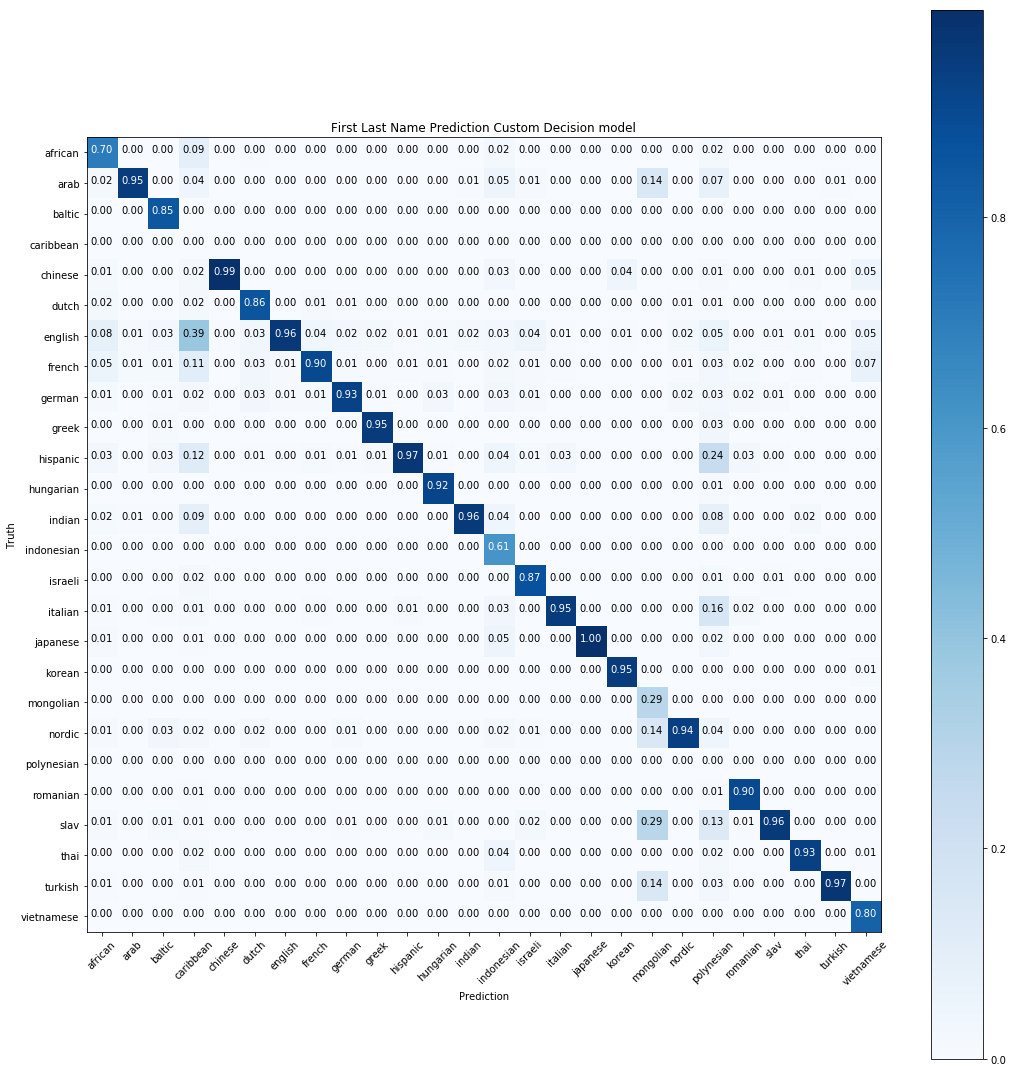

In [386]:
print("{} : {}".format("Prediction Custom Decision",np.sum(np.array(pred_custom_decision)==test_labels)/len(test_labels)))
cnf_matrix = confusion_matrix(test_labels,pred_custom_decision)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                      title="{} model".format("First Last Name Prediction Custom Decision"))

plt.show()

In [385]:
display(conf_table(pred_custom_decision,test_labels))

,precision,recall,precision-1,precision-2,precision-3,recall-1,recall-2,recall-3
african,0.704573,0.638321,"(african, 0.704572803851)","(english, 0.0836341756919)","(french, 0.0532490974729)","(african, 0.638321068411)","(polynesian, 0.12755519215)","(english, 0.0902153175252)"
arab,0.949433,0.894822,"(arab, 0.949433061468)","(french, 0.0136463099264)","(english, 0.00982693455341)","(arab, 0.894821703101)","(polynesian, 0.0757808691739)","(indian, 0.00727436349319)"
baltic,0.849206,0.861745,"(baltic, 0.849206349206)","(nordic, 0.0330687830688)","(english, 0.0251322751323)","(baltic, 0.861744966443)","(polynesian, 0.0791946308725)","(nordic, 0.0107382550336)"
caribbean,0.002320,0.047619,"(english, 0.385150812065)","(hispanic, 0.120649651972)","(french, 0.106728538283)","(english, 0.428571428571)","(polynesian, 0.190476190476)","(indian, 0.0952380952381)"
chinese,0.990920,0.981166,"(chinese, 0.990920415888)","(english, 0.00470748886014)","(korean, 0.00125772603134)","(chinese, 0.981165642717)","(korean, 0.00734160400408)","(english, 0.00410370756932)"
dutch,0.856028,0.873822,"(dutch, 0.856028450155)","(english, 0.034644946656)","(french, 0.0327520936102)","(dutch, 0.873821652322)","(english, 0.0351308624627)","(french, 0.0291000644066)"
english,0.964208,0.968642,"(english, 0.964207906457)","(german, 0.00852488176165)","(french, 0.00831805082526)","(english, 0.968642213018)","(german, 0.00579365848929)","(french, 0.0055928024269)"
french,0.900739,0.858978,"(french, 0.900738807188)","(english, 0.0376395459948)","(german, 0.0149858997366)","(french, 0.858978063254)","(english, 0.0536305647545)","(german, 0.0210032671749)"
german,0.925300,0.915465,"(german, 0.925300058753)","(english, 0.0234031838402)","(nordic, 0.0138488655121)","(german, 0.915464887757)","(english, 0.0342264788109)","(polynesian, 0.0103108478423)"
greek,0.950922,0.856302,"(greek, 0.950922027007)","(english, 0.0194569478728)","(hispanic, 0.00842166400465)","(greek, 0.856302301255)","(polynesian, 0.118462343096)","(english, 0.0111140167364)"


In [240]:
"""
sample.reset()
nextList = sample.genNext()
first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

preds = first_last_name_model.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(nextList),len(pub_keys)))],verbose=True,batch_size=1000)
"""


10000/10004 [============================>.] - ETA: 0s

___
## Confusion Matrix

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


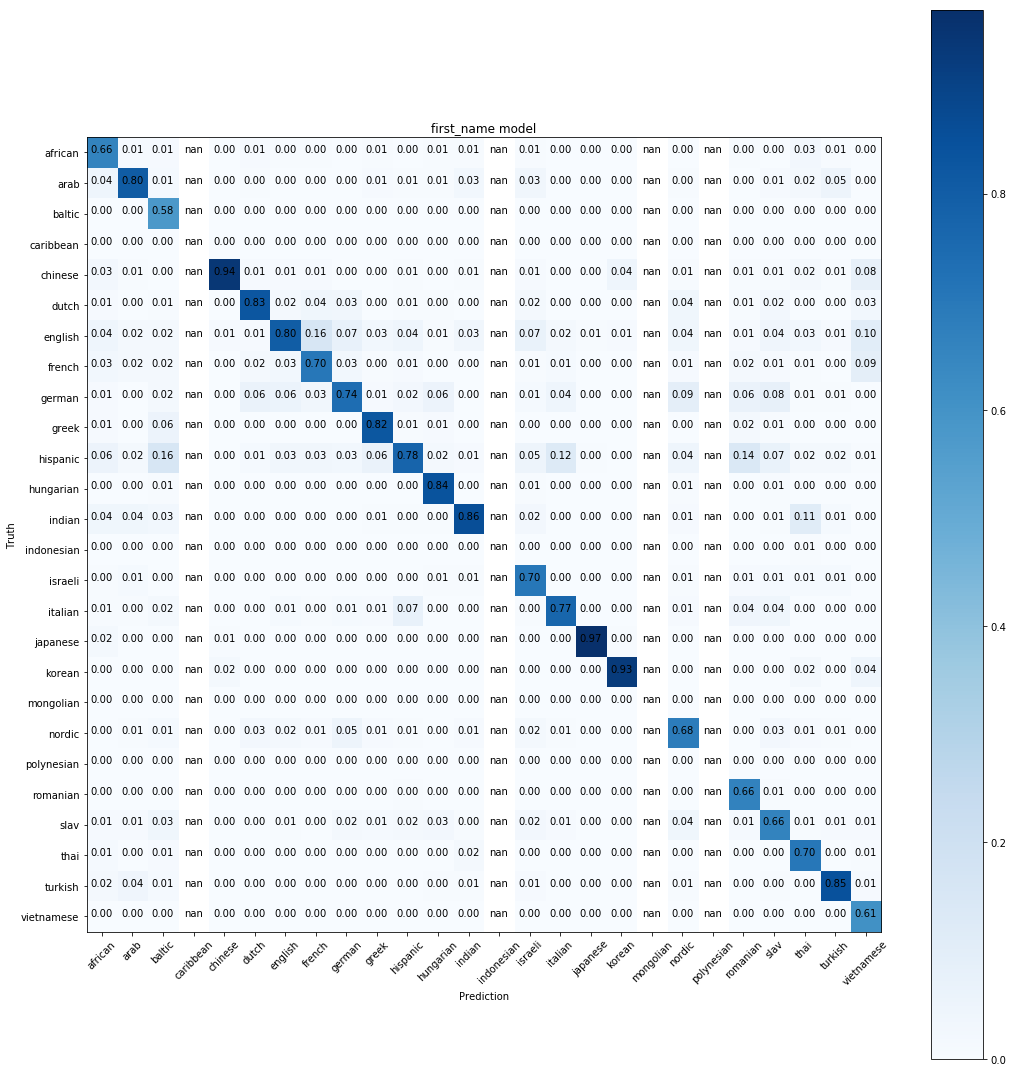

Normalized confusion matrix


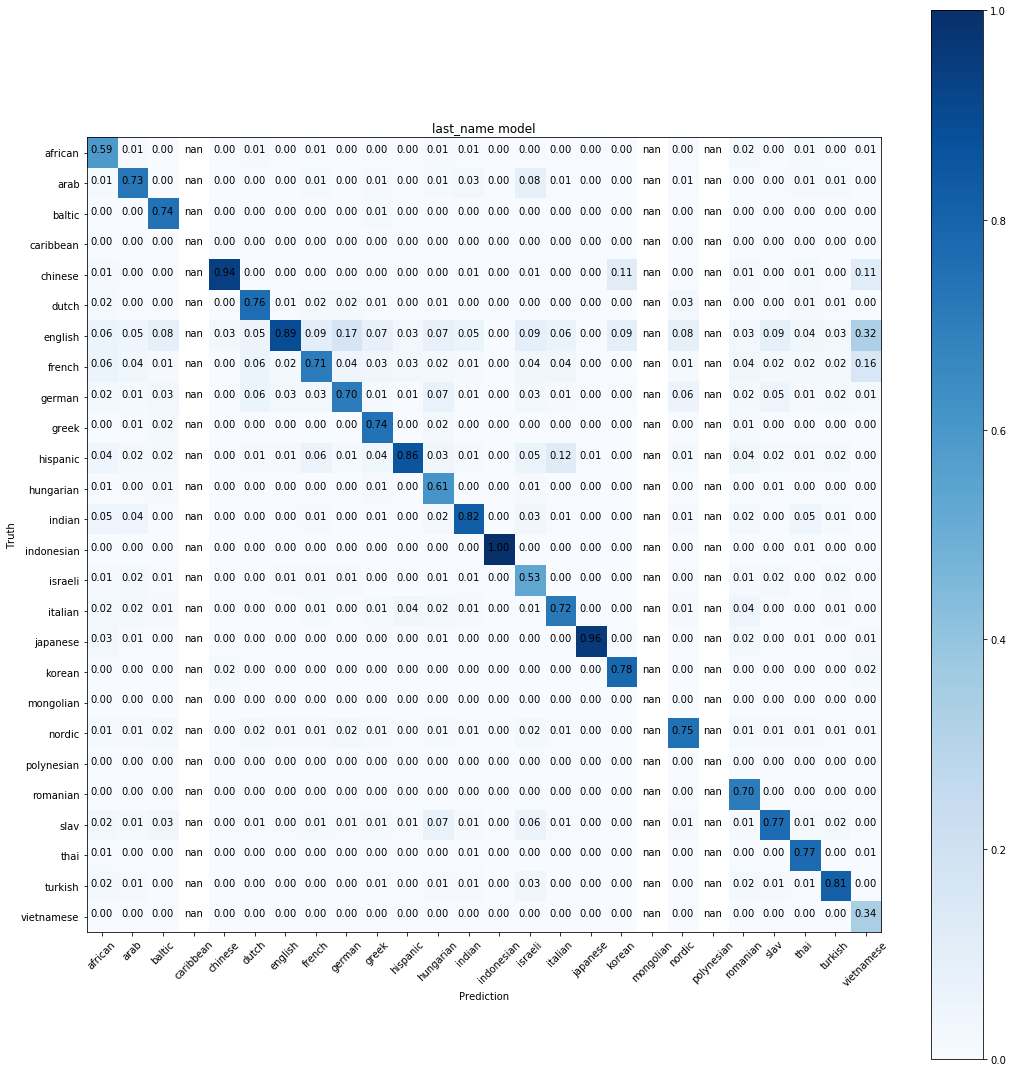

Normalized confusion matrix


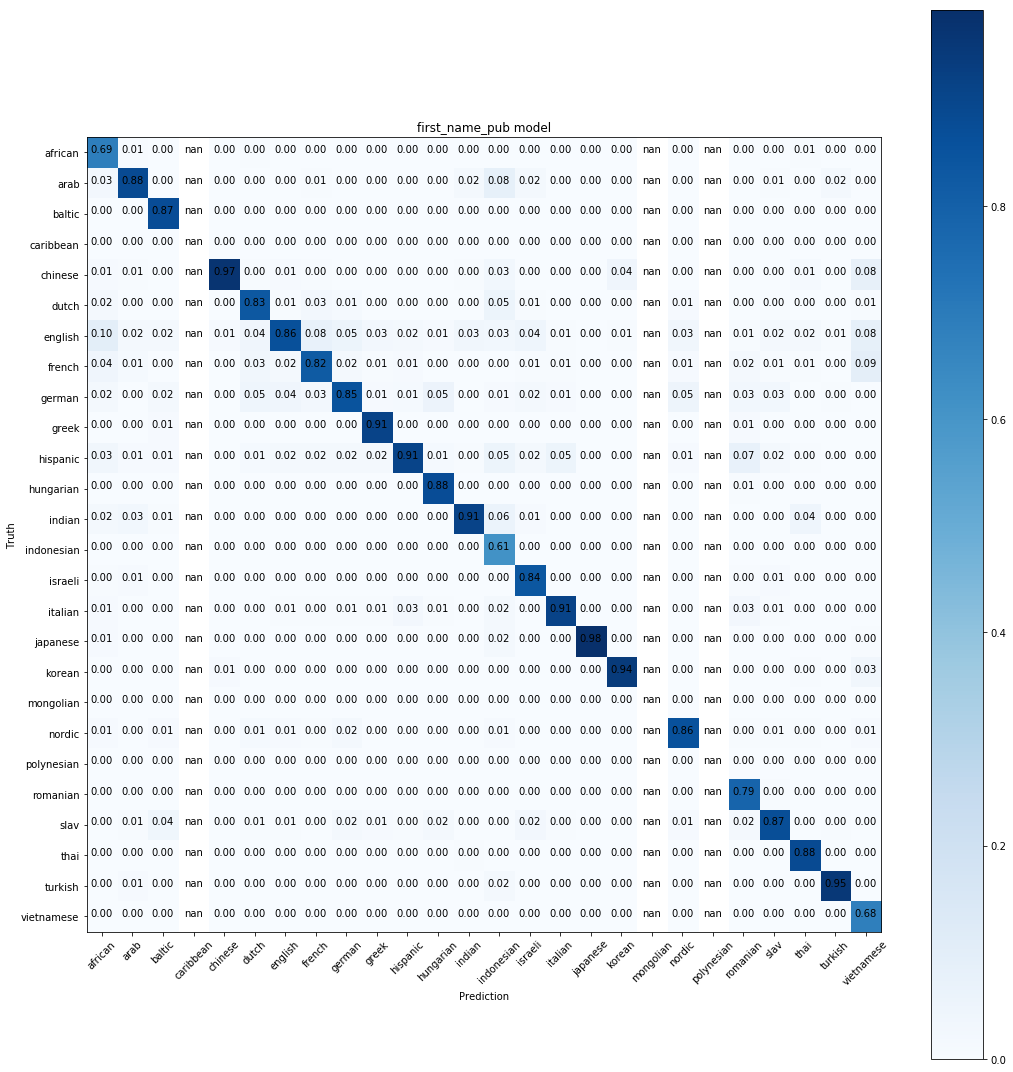

Normalized confusion matrix


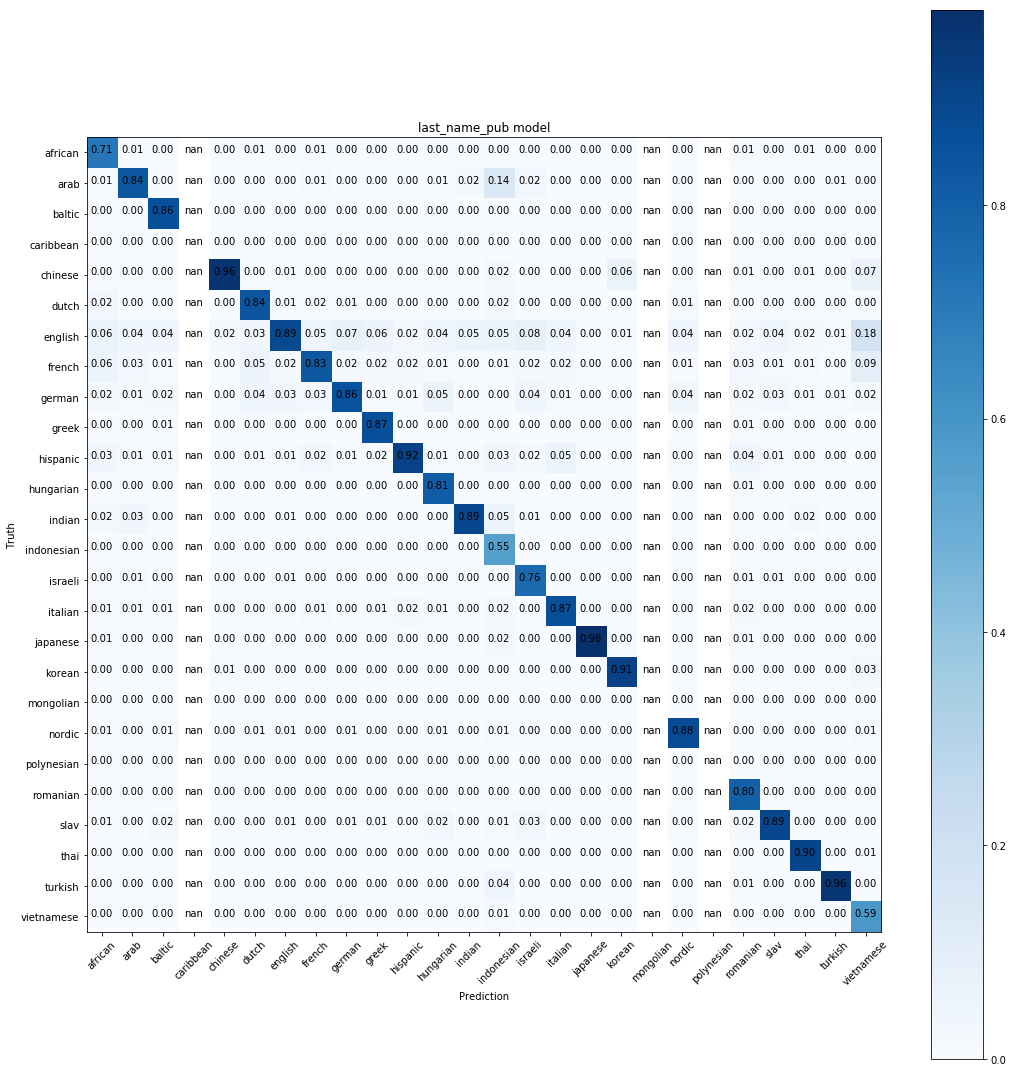

Normalized confusion matrix


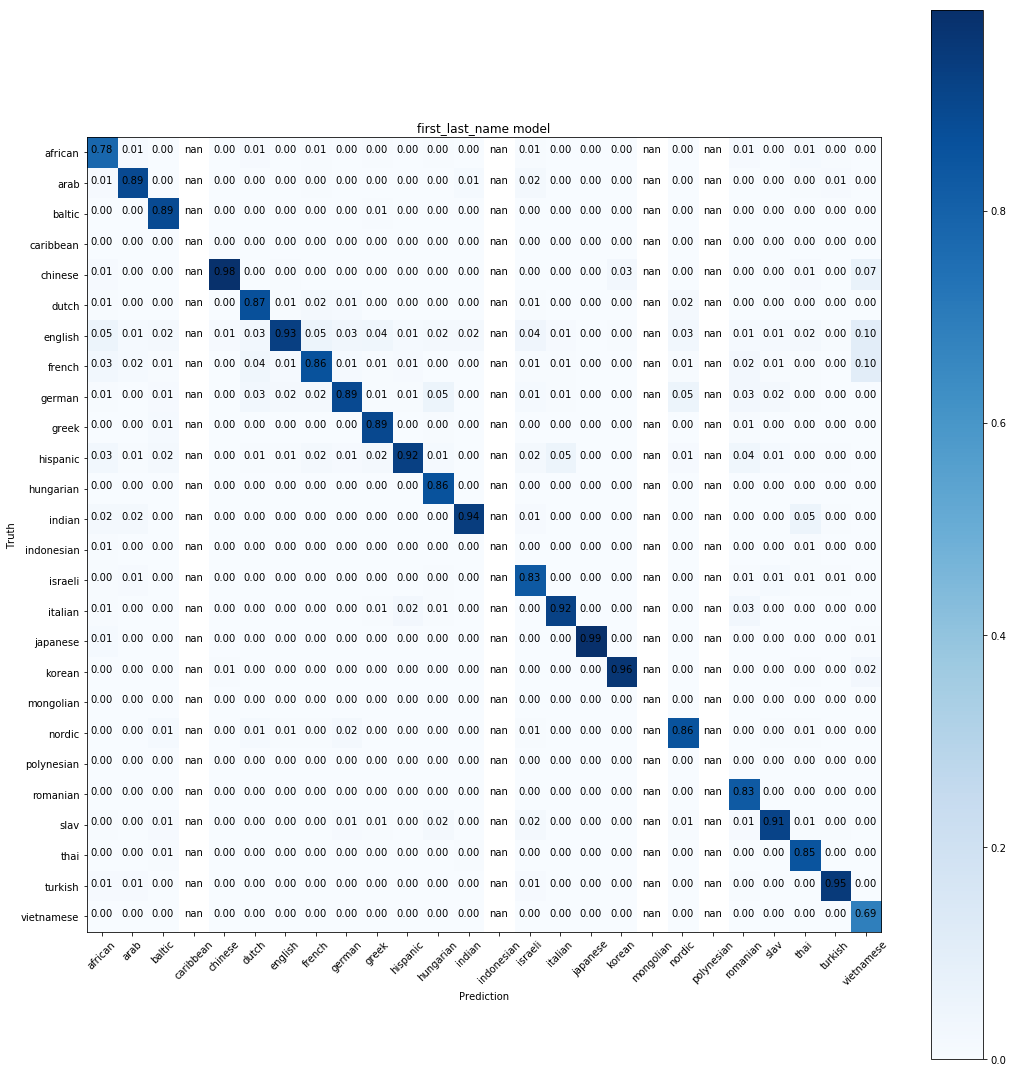

Normalized confusion matrix


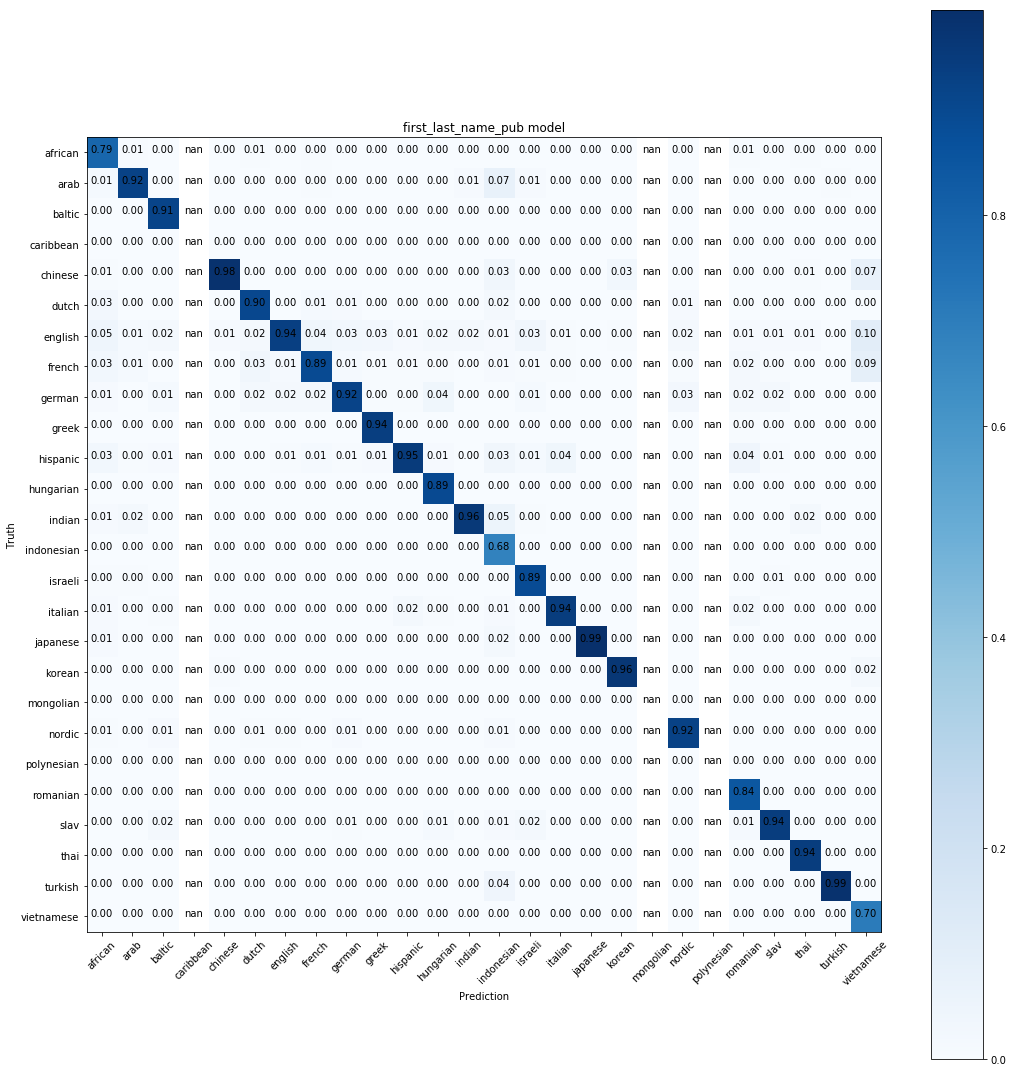

In [34]:
# Compute confusion matrix
for i in range(6):
    cnf_matrix = confusion_matrix(test_labels,pred_class[i])
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


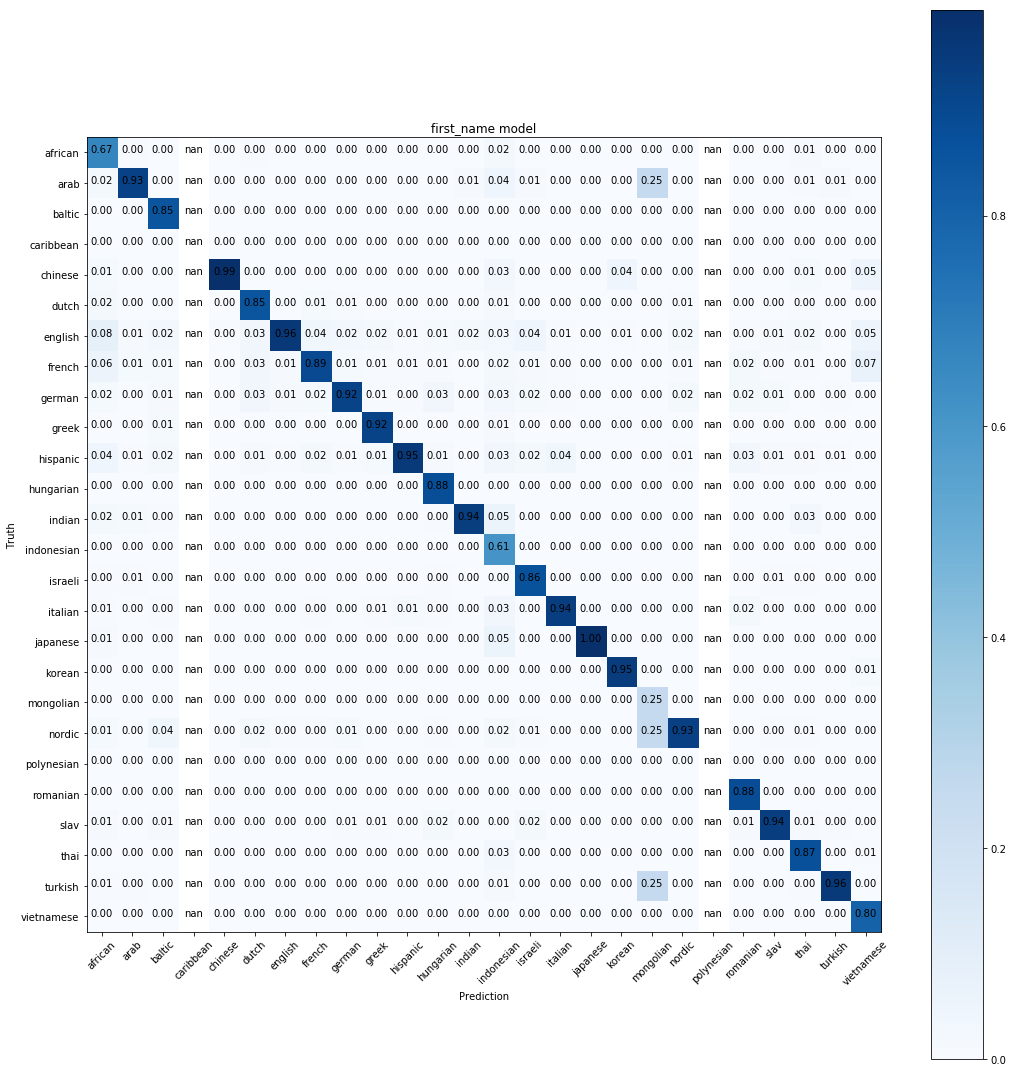

Normalized confusion matrix


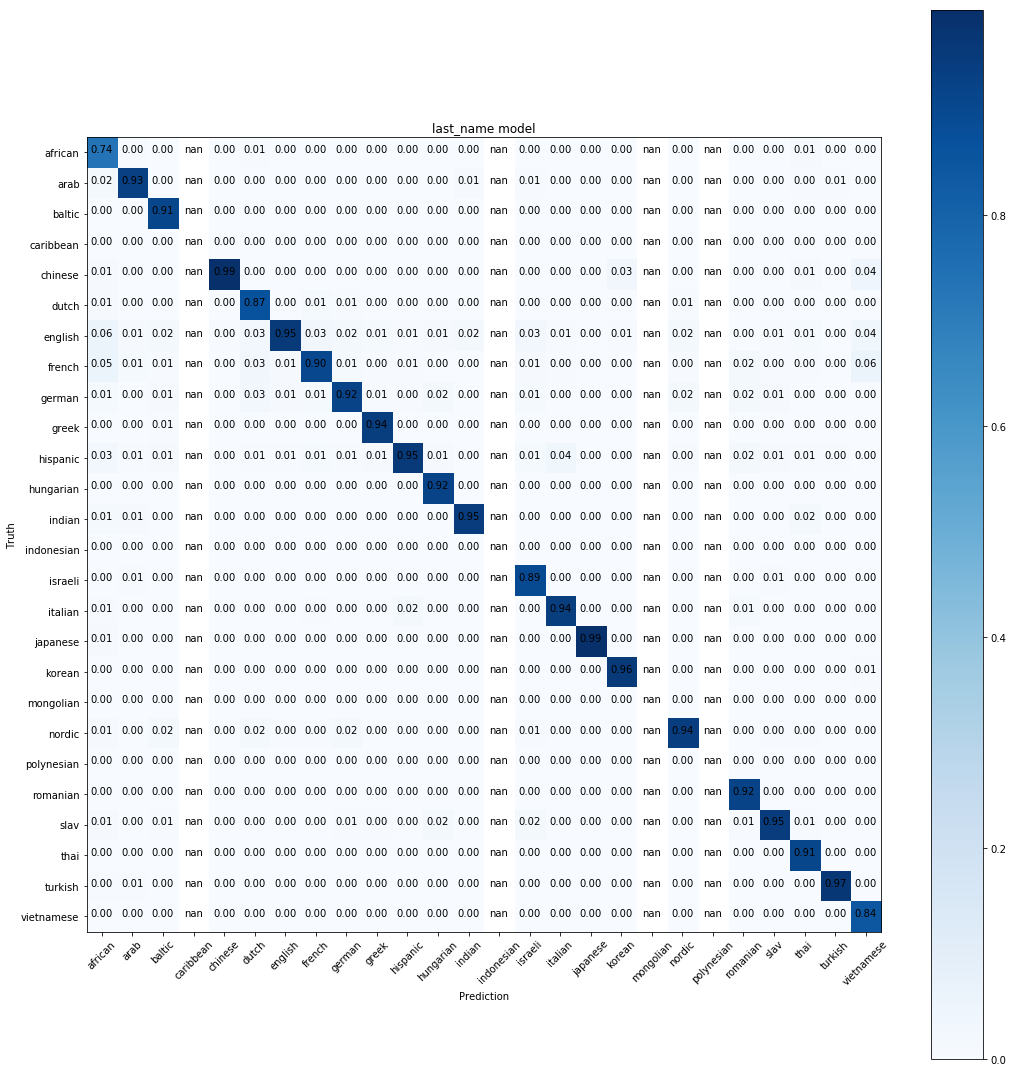

In [284]:
# Compute confusion matrix
for i in range(2):
    cnf_matrix = confusion_matrix(test_labels,pred_class[i])
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [ ]:
# convert categorical to binary crossentropy
#trainY = np.array([np.where(x>0)[0][0] for x in trainY])
#testY = np.array([np.where(x>0)[0][0] for x in testY])

#test_res

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(lten(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [4]:
testX

array([[  112,  1331,  1332, ...,     0,     0,     0],
       [  251,   252,   232, ...,     0,     0,     0],
       [ 4633, 11731, 23123, ...,     0,     0,     0],
       ..., 
       [  696,   697,   698, ...,     0,     0,     0],
       [   25,    26,  5195, ...,     0,     0,     0],
       [ 8671,  8672,  6568, ...,     0,     0,     0]], dtype=int32)

In [91]:
# store the predictions probabilities, predictions and labels
"""
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

pred_prob = []
predictions = []
"""

def evaluate_probs(firstX, lastX, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = []    
    pred_prob = []
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        #pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        pred = model.predict([y_first_trainX,y_last_trainX])
        pred_class_inn =  [np.argsort(x)[::-1][0] for x in pred]
        pred_class.extend(pred_class_inn)
        pred_prob.extend([x[np.argsort(x)[::-1][0]] for x in pred])
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [92]:
#pred_class, pred_prob = evaluate_probs(first_testX[0:100],last_testX[0:100], testY[0:100], testIndex)
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


(array([  2.07000000e+02,   2.28700000e+03,   7.56300000e+03,
          1.39370000e+04,   2.28850000e+04,   2.34090000e+04,
          2.51430000e+04,   3.02170000e+04,   4.46390000e+04,
          7.16530000e+05]),
 array([ 0.14609675,  0.23148708,  0.3168774 ,  0.40226773,  0.48765805,
         0.57304838,  0.6584387 ,  0.74382903,  0.82921935,  0.91460968,  1.        ]),
 <a list of 10 Patch objects>)

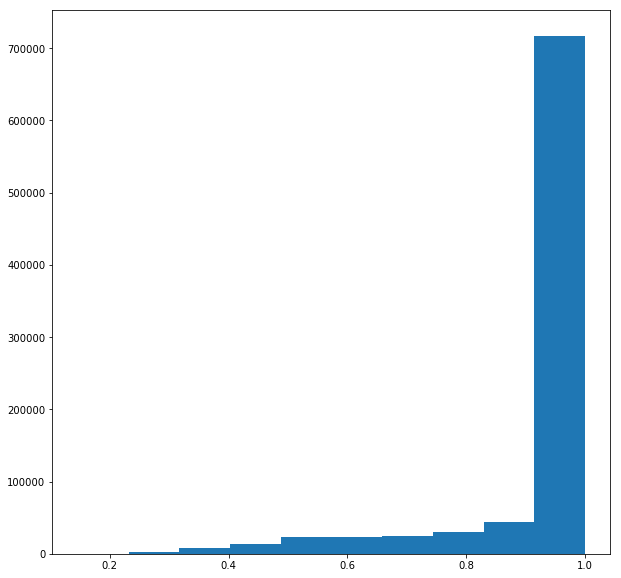

In [95]:
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(pred_prob)

In [102]:
pred_class = np.array(pred_class)
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

Confusion matrix, without normalization


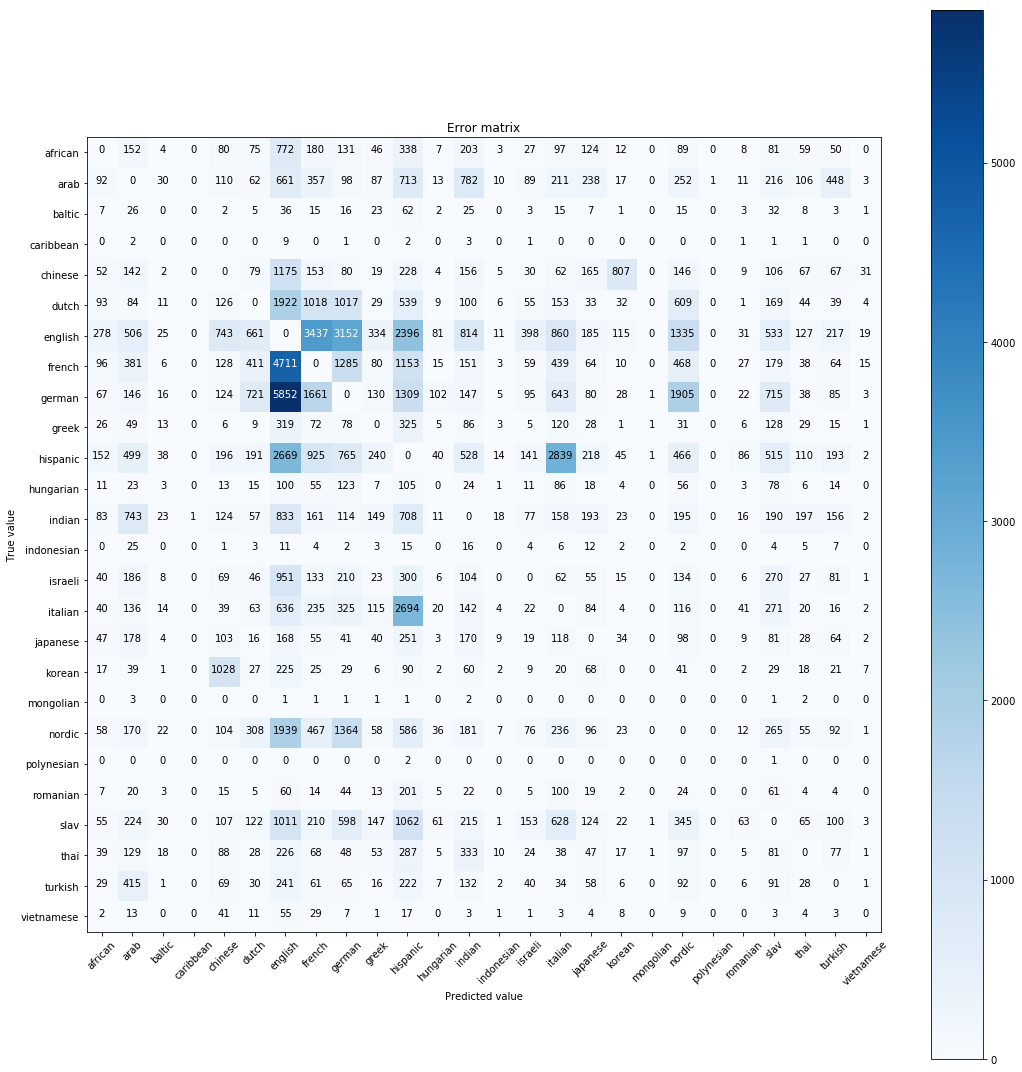

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [111]:
len(struct_dict_keys)

725

In [112]:
struct_dict_keys

['_c',
 'ca',
 'am',
 'me',
 'er',
 'ro',
 'on',
 'n_',
 '_b',
 'be',
 'rt',
 't_',
 '_l',
 'le',
 'ee',
 'en',
 '_e',
 'es',
 'st',
 'th',
 'he',
 'r_',
 'el',
 'll',
 '_p',
 'pe',
 'et',
 'te',
 '_g',
 'ge',
 '_m',
 'ma',
 'ax',
 'x_',
 '_k',
 'kh',
 'ha',
 'al',
 'ed',
 'd_',
 'la',
 'an',
 'ni',
 'ie',
 'e_',
 'eu',
 'un',
 'ic',
 'ce',
 'ch',
 'hr',
 'ri',
 'is',
 'to',
 'op',
 'ph',
 '_j',
 'jo',
 'oo',
 'os',
 '_i',
 'ia',
 'ka',
 'at',
 'hl',
 '_t',
 'rr',
 're',
 'nc',
 'ju',
 'ul',
 'li',
 'iu',
 'us',
 's_',
 '_a',
 'mr',
 'mi',
 'ig',
 'gu',
 'ue',
 'l_',
 '_n',
 'ne',
 'ei',
 'il',
 'je',
 'oe',
 '_h',
 'hy',
 'yu',
 'ah',
 'h_',
 'ar',
 'rk',
 'k_',
 'ab',
 'bd',
 '_s',
 'se',
 'rg',
 'gi',
 'io',
 'o_',
 'uu',
 'dr',
 'pa',
 'au',
 'ja',
 'ik',
 'ke',
 'mu',
 'ir',
 'na',
 '_r',
 'rd',
 'rn',
 'ns',
 'as',
 'sw',
 'wa',
 'nt',
 'ur',
 '_d',
 'de',
 'og',
 'ho',
 'or',
 'ra',
 'ay',
 'ya',
 'a_',
 'em',
 'ad',
 'ak',
 'su',
 'u_',
 '_y',
 'yo',
 'ou',
 'si',
 'if',
 'f_',